# Montecarlo Approximator

##  1. Importing Libraries

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [14]:
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict
from typing import List
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gym
import src.serializer as serializer
import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

##  2. Auxiliary functions

### 2.1 Print Result

In [15]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [16]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [17]:
RAM_full_mask=[14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 18  # Chicken Collision flag (with the bottom car)
    , 22  # Car X Direction
    , 23, 24, 25, 26, 27, 28, 29, 30, 31, 32  # Z Car Patterns
    , 33, 34, 35, 36, 37, 38, 39, 40, 41, 42  # Car Motion Timmers
    , 43, 44, 45, 46, 47, 48, 49, 50, 51, 52  # Car Motions
    , 87, 88  # Car Shape Ptr
    # TODO: test if this makes any difference
    , 89, 90  # Chicken Shape Ptr
    # TODO: test if this makes any difference
    #, 106, 107  # Chicken Sounds
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]  # Car X Coords

###  2.2 Reduce State

In [18]:
def reduce_state_distance(ob):
    
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        ob[b] = abs(ob[b] - 50)
        if b<=112:
            ob[b]*=-1
        ob[b] = ob[b] // 3
        # The chicken is in the x-posistion ~49
        #if ob[b] < 20 or ob[b] > 80:
        #   # We don't need to represent cars far from the chicken
        #    ob[b] = 0
        #else:
        #    # Reduce the cars x-positions sample space
        #    ob[b] = ob[b] // 3

    return ob

Ideias para os aproximadores de função:
* não utilizar o `ob = reduce_state(ob)`. Fazer apenas `state = ob[RAM_mask].data.tobytes()`
* outro teste pode ser utilzar uma transformação no estado do jogo fazendo os bytes da pos X do carro ficarem +- em linha com a distância, uma possível transformação seria algo como

for b in range(108, 118):
    ob[b] = abs(ob[b] - 50)

Dá para alterar a função reduce_state e colocar esse código lá ao invés dos outro código (e lembrar de reativar essa função).
* Tentar multiplicar por -1 os 5 primeiros carros (talvez facilite o aproximador a entender o que deve fazer)

In [19]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

### 2.3 Saving and Load History

In [20]:
def saveHistory(config,scores,total_rewards):
    base="history/"
    with open(base+"scores_"+config+".pickle", 'wb') as handle:
        pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(base+"total_rewards_"+config+".pickle", 'wb') as handle:
        pickle.dump(total_rewards, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    print("Scores and Total rewards for "+config+" saved")

def loadHistory(fileDir):
    with open(fileDir, 'rb') as handle:
        data = pickle.load(handle)
        return data

###  2.4 Reward Policy

In [21]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

## 3. Running algorithms

### 3.1 Setting Parameters

In [22]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 0.001
#2 ações 
#- Recompensa R3 (+500 se cruzar a rua, -10 para colisão, -1 se ficar parado)
#- N0 = 0.001 
#- gamma = 0.99
reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1

## 3.2 Montecarlo approximator

### 3.2.1 Features Distance + StandarScaler

In [41]:
# setting reduce type
reduce=reduce_state_distance
n_features=12

In [72]:
def MonteCarloAprox(RAM_mask: List[int], render: bool=False,feat_type: str="all"):
    epi = episode.generate_episode(env, reduce_state=reduce, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.updating(epi)

In [73]:
env, initial_state = environment.get_env()

In [74]:
agent = agents.MonteCarloAprox(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0,nFeatures=n_features,scaler=StandardScaler(),feat_type= "all")

In [75]:
agent.trainScaler(env,RAM_mask)

In [76]:
scores = []
total_rewards = []

In [77]:
%%time

n_runs = 5000

for i in tqdm(range(n_runs)):
    render = i % 201 == 200

    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render,feat_type="all")

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)
    """
    if i % 500 == 0:
      exp = serializer.Experiment(ql_agent_app, scores, total_rewards, reduce_state, reward_policy)
      exp.save_experiment(modelSavePath,'model_ql_approximator_'+str(i))
      print("Model saved!")
    """

  0%|          | 1/5000 [00:04<5:34:26,  4.01s/it]

Run [   0] - Total reward: 3408.00 Mean scores: 11.00 Means Scores[:-10]: 11.00 Score: 11 


  0%|          | 11/5000 [00:42<5:21:40,  3.87s/it]

Run [  10] - Total reward: 5289.00 Mean scores: 12.18 Means Scores[:-10]: 12.30 Score: 14 


  0%|          | 21/5000 [01:20<5:10:39,  3.74s/it]

Run [  20] - Total reward: 5256.00 Mean scores: 13.24 Means Scores[:-10]: 14.40 Score: 14 


  1%|          | 31/5000 [01:57<5:06:04,  3.70s/it]

Run [  30] - Total reward: 7084.00 Mean scores: 14.32 Means Scores[:-10]: 16.60 Score: 17 


  1%|          | 41/5000 [02:34<5:11:13,  3.77s/it]

Run [  40] - Total reward: 9476.00 Mean scores: 15.34 Means Scores[:-10]: 18.50 Score: 21 


  1%|          | 51/5000 [03:12<5:09:31,  3.75s/it]

Run [  50] - Total reward: 8902.00 Mean scores: 16.16 Means Scores[:-10]: 19.50 Score: 20 


  1%|          | 61/5000 [03:48<4:56:06,  3.60s/it]

Run [  60] - Total reward: 8797.00 Mean scores: 16.72 Means Scores[:-10]: 19.60 Score: 20 


  1%|▏         | 71/5000 [04:25<5:03:41,  3.70s/it]

Run [  70] - Total reward: 7958.00 Mean scores: 16.93 Means Scores[:-10]: 18.20 Score: 18 


  2%|▏         | 81/5000 [05:01<4:42:27,  3.45s/it]

Run [  80] - Total reward: 9002.00 Mean scores: 17.26 Means Scores[:-10]: 19.60 Score: 20 


  2%|▏         | 91/5000 [05:35<4:49:42,  3.54s/it]

Run [  90] - Total reward: 10021.00 Mean scores: 17.64 Means Scores[:-10]: 20.70 Score: 22 


  2%|▏         | 101/5000 [06:12<4:45:26,  3.50s/it]

Run [ 100] - Total reward: 9628.00 Mean scores: 18.00 Means Scores[:-10]: 21.30 Score: 21 


  2%|▏         | 111/5000 [06:45<4:29:53,  3.31s/it]

Run [ 110] - Total reward: 8463.00 Mean scores: 18.23 Means Scores[:-10]: 20.60 Score: 19 


  2%|▏         | 121/5000 [07:18<4:25:07,  3.26s/it]

Run [ 120] - Total reward: 9618.00 Mean scores: 18.44 Means Scores[:-10]: 20.70 Score: 21 


  3%|▎         | 131/5000 [07:52<4:30:45,  3.34s/it]

Run [ 130] - Total reward: 9640.00 Mean scores: 18.64 Means Scores[:-10]: 21.10 Score: 21 


  3%|▎         | 141/5000 [08:24<4:25:04,  3.27s/it]

Run [ 140] - Total reward: 9052.00 Mean scores: 18.76 Means Scores[:-10]: 20.30 Score: 20 


  3%|▎         | 151/5000 [08:57<4:24:06,  3.27s/it]

Run [ 150] - Total reward: 9601.00 Mean scores: 18.89 Means Scores[:-10]: 20.80 Score: 21 


  3%|▎         | 161/5000 [09:30<4:24:05,  3.27s/it]

Run [ 160] - Total reward: 10125.00 Mean scores: 19.07 Means Scores[:-10]: 21.80 Score: 22 


  3%|▎         | 171/5000 [10:03<4:22:19,  3.26s/it]

Run [ 170] - Total reward: 10745.00 Mean scores: 19.27 Means Scores[:-10]: 22.40 Score: 23 


  4%|▎         | 181/5000 [10:36<4:22:44,  3.27s/it]

Run [ 180] - Total reward: 10743.00 Mean scores: 19.45 Means Scores[:-10]: 22.60 Score: 23 


  4%|▍         | 191/5000 [11:09<4:24:14,  3.30s/it]

Run [ 190] - Total reward: 10268.00 Mean scores: 19.57 Means Scores[:-10]: 21.60 Score: 22 


  4%|▍         | 201/5000 [12:01<12:23:15,  9.29s/it]

Run [ 200] - Total reward: 9995.00 Mean scores: 19.74 Means Scores[:-10]: 23.10 Score: 22 


  4%|▍         | 211/5000 [12:33<4:27:16,  3.35s/it] 

Run [ 210] - Total reward: 10182.00 Mean scores: 19.87 Means Scores[:-10]: 22.40 Score: 22 


  4%|▍         | 221/5000 [13:05<4:17:35,  3.23s/it]

Run [ 220] - Total reward: 11856.00 Mean scores: 19.97 Means Scores[:-10]: 22.10 Score: 25 


  5%|▍         | 231/5000 [13:37<4:18:51,  3.26s/it]

Run [ 230] - Total reward: 10162.00 Mean scores: 20.06 Means Scores[:-10]: 22.20 Score: 22 


  5%|▍         | 241/5000 [14:10<4:16:05,  3.23s/it]

Run [ 240] - Total reward: 9607.00 Mean scores: 20.20 Means Scores[:-10]: 23.30 Score: 21 


  5%|▌         | 251/5000 [14:42<4:15:16,  3.23s/it]

Run [ 250] - Total reward: 11417.00 Mean scores: 20.33 Means Scores[:-10]: 23.60 Score: 24 


  5%|▌         | 261/5000 [15:15<4:12:54,  3.20s/it]

Run [ 260] - Total reward: 10245.00 Mean scores: 20.43 Means Scores[:-10]: 22.90 Score: 22 


  5%|▌         | 271/5000 [15:47<4:15:50,  3.25s/it]

Run [ 270] - Total reward: 11249.00 Mean scores: 20.53 Means Scores[:-10]: 23.00 Score: 24 


  6%|▌         | 281/5000 [16:21<4:20:19,  3.31s/it]

Run [ 280] - Total reward: 10189.00 Mean scores: 20.60 Means Scores[:-10]: 22.60 Score: 22 


  6%|▌         | 291/5000 [16:53<4:11:25,  3.20s/it]

Run [ 290] - Total reward: 11766.00 Mean scores: 20.73 Means Scores[:-10]: 24.20 Score: 25 


  6%|▌         | 301/5000 [17:25<4:10:46,  3.20s/it]

Run [ 300] - Total reward: 10245.00 Mean scores: 20.82 Means Scores[:-10]: 23.60 Score: 22 


  6%|▌         | 311/5000 [17:57<4:11:09,  3.21s/it]

Run [ 310] - Total reward: 10875.00 Mean scores: 20.89 Means Scores[:-10]: 22.90 Score: 23 


  6%|▋         | 321/5000 [18:29<4:07:50,  3.18s/it]

Run [ 320] - Total reward: 9672.00 Mean scores: 20.97 Means Scores[:-10]: 23.40 Score: 21 


  7%|▋         | 331/5000 [19:01<4:07:25,  3.18s/it]

Run [ 330] - Total reward: 9744.00 Mean scores: 21.02 Means Scores[:-10]: 22.80 Score: 21 


  7%|▋         | 341/5000 [19:33<4:06:17,  3.17s/it]

Run [ 340] - Total reward: 11829.00 Mean scores: 21.10 Means Scores[:-10]: 23.60 Score: 25 


  7%|▋         | 351/5000 [20:05<4:08:31,  3.21s/it]

Run [ 350] - Total reward: 9711.00 Mean scores: 21.13 Means Scores[:-10]: 22.10 Score: 21 


  7%|▋         | 361/5000 [20:37<4:05:18,  3.17s/it]

Run [ 360] - Total reward: 10697.00 Mean scores: 21.16 Means Scores[:-10]: 22.40 Score: 23 


  7%|▋         | 371/5000 [21:09<4:07:00,  3.20s/it]

Run [ 370] - Total reward: 10742.00 Mean scores: 21.20 Means Scores[:-10]: 22.70 Score: 23 


  8%|▊         | 381/5000 [21:41<4:16:03,  3.33s/it]

Run [ 380] - Total reward: 9214.00 Mean scores: 21.22 Means Scores[:-10]: 22.00 Score: 20 


  8%|▊         | 391/5000 [22:13<4:04:36,  3.18s/it]

Run [ 390] - Total reward: 10219.00 Mean scores: 21.26 Means Scores[:-10]: 22.50 Score: 22 


  8%|▊         | 401/5000 [22:45<4:03:54,  3.18s/it]

Run [ 400] - Total reward: 10219.00 Mean scores: 21.29 Means Scores[:-10]: 22.80 Score: 22 


  8%|▊         | 411/5000 [23:34<4:17:57,  3.37s/it] 

Run [ 410] - Total reward: 11353.00 Mean scores: 21.33 Means Scores[:-10]: 22.60 Score: 24 


  8%|▊         | 421/5000 [24:09<4:18:44,  3.39s/it]

Run [ 420] - Total reward: 9739.00 Mean scores: 21.35 Means Scores[:-10]: 22.20 Score: 21 


  9%|▊         | 431/5000 [24:43<4:14:11,  3.34s/it]

Run [ 430] - Total reward: 9599.00 Mean scores: 21.35 Means Scores[:-10]: 21.40 Score: 21 


  9%|▉         | 441/5000 [25:16<4:05:58,  3.24s/it]

Run [ 440] - Total reward: 11299.00 Mean scores: 21.37 Means Scores[:-10]: 22.40 Score: 24 


  9%|▉         | 451/5000 [25:48<4:08:51,  3.28s/it]

Run [ 450] - Total reward: 10880.00 Mean scores: 21.39 Means Scores[:-10]: 22.30 Score: 23 


  9%|▉         | 461/5000 [26:20<4:03:07,  3.21s/it]

Run [ 460] - Total reward: 10128.00 Mean scores: 21.41 Means Scores[:-10]: 22.00 Score: 22 


  9%|▉         | 471/5000 [26:52<4:02:39,  3.21s/it]

Run [ 470] - Total reward: 11251.00 Mean scores: 21.44 Means Scores[:-10]: 22.90 Score: 24 


 10%|▉         | 481/5000 [27:24<3:56:24,  3.14s/it]

Run [ 480] - Total reward: 9611.00 Mean scores: 21.46 Means Scores[:-10]: 22.40 Score: 21 


 10%|▉         | 491/5000 [27:57<3:58:34,  3.17s/it]

Run [ 490] - Total reward: 11216.00 Mean scores: 21.48 Means Scores[:-10]: 22.50 Score: 24 


 10%|█         | 501/5000 [28:29<3:59:22,  3.19s/it]

Run [ 500] - Total reward: 10793.00 Mean scores: 21.50 Means Scores[:-10]: 22.60 Score: 23 


 10%|█         | 511/5000 [29:01<4:00:06,  3.21s/it]

Run [ 510] - Total reward: 10809.00 Mean scores: 21.54 Means Scores[:-10]: 23.50 Score: 23 


 10%|█         | 521/5000 [29:33<3:59:30,  3.21s/it]

Run [ 520] - Total reward: 12262.00 Mean scores: 21.58 Means Scores[:-10]: 23.50 Score: 26 


 11%|█         | 531/5000 [30:06<3:58:59,  3.21s/it]

Run [ 530] - Total reward: 10707.00 Mean scores: 21.60 Means Scores[:-10]: 23.00 Score: 23 


 11%|█         | 541/5000 [30:38<3:59:15,  3.22s/it]

Run [ 540] - Total reward: 12276.00 Mean scores: 21.64 Means Scores[:-10]: 23.70 Score: 26 


 11%|█         | 551/5000 [31:10<3:58:41,  3.22s/it]

Run [ 550] - Total reward: 11672.00 Mean scores: 21.67 Means Scores[:-10]: 23.00 Score: 25 


 11%|█         | 561/5000 [31:42<4:00:24,  3.25s/it]

Run [ 560] - Total reward: 9691.00 Mean scores: 21.70 Means Scores[:-10]: 23.50 Score: 21 


 11%|█▏        | 571/5000 [32:14<3:54:21,  3.17s/it]

Run [ 570] - Total reward: 11213.00 Mean scores: 21.72 Means Scores[:-10]: 22.60 Score: 24 


 12%|█▏        | 581/5000 [32:46<3:55:07,  3.19s/it]

Run [ 580] - Total reward: 10755.00 Mean scores: 21.74 Means Scores[:-10]: 23.10 Score: 23 


 12%|█▏        | 591/5000 [33:18<3:52:45,  3.17s/it]

Run [ 590] - Total reward: 10790.00 Mean scores: 21.76 Means Scores[:-10]: 23.00 Score: 23 


 12%|█▏        | 601/5000 [33:50<3:55:53,  3.22s/it]

Run [ 600] - Total reward: 10747.00 Mean scores: 21.80 Means Scores[:-10]: 23.90 Score: 23 


 12%|█▏        | 611/5000 [34:40<4:11:53,  3.44s/it] 

Run [ 610] - Total reward: 11220.00 Mean scores: 21.82 Means Scores[:-10]: 23.00 Score: 24 


 12%|█▏        | 621/5000 [35:11<3:52:04,  3.18s/it]

Run [ 620] - Total reward: 11405.00 Mean scores: 21.85 Means Scores[:-10]: 23.70 Score: 24 


 13%|█▎        | 631/5000 [35:44<4:03:53,  3.35s/it]

Run [ 630] - Total reward: 10594.00 Mean scores: 21.88 Means Scores[:-10]: 24.10 Score: 23 


 13%|█▎        | 641/5000 [36:16<3:51:30,  3.19s/it]

Run [ 640] - Total reward: 11271.00 Mean scores: 21.91 Means Scores[:-10]: 23.90 Score: 24 


 13%|█▎        | 651/5000 [36:48<3:51:56,  3.20s/it]

Run [ 650] - Total reward: 11396.00 Mean scores: 21.93 Means Scores[:-10]: 22.70 Score: 24 


 13%|█▎        | 661/5000 [37:19<3:49:37,  3.18s/it]

Run [ 660] - Total reward: 9722.00 Mean scores: 21.94 Means Scores[:-10]: 22.80 Score: 21 


 13%|█▎        | 671/5000 [37:52<3:53:53,  3.24s/it]

Run [ 670] - Total reward: 9667.00 Mean scores: 21.94 Means Scores[:-10]: 22.00 Score: 21 


 14%|█▎        | 681/5000 [38:24<3:53:56,  3.25s/it]

Run [ 680] - Total reward: 11373.00 Mean scores: 21.96 Means Scores[:-10]: 23.20 Score: 24 


 14%|█▍        | 691/5000 [38:56<3:46:03,  3.15s/it]

Run [ 690] - Total reward: 11292.00 Mean scores: 21.98 Means Scores[:-10]: 23.60 Score: 24 


 14%|█▍        | 701/5000 [39:27<3:46:11,  3.16s/it]

Run [ 700] - Total reward: 9704.00 Mean scores: 21.99 Means Scores[:-10]: 22.30 Score: 21 


 14%|█▍        | 711/5000 [40:00<3:51:20,  3.24s/it]

Run [ 710] - Total reward: 9630.00 Mean scores: 21.99 Means Scores[:-10]: 22.40 Score: 21 


 14%|█▍        | 721/5000 [40:32<3:47:02,  3.18s/it]

Run [ 720] - Total reward: 12987.00 Mean scores: 22.01 Means Scores[:-10]: 23.30 Score: 27 


 15%|█▍        | 731/5000 [41:04<3:45:50,  3.17s/it]

Run [ 730] - Total reward: 11868.00 Mean scores: 22.01 Means Scores[:-10]: 21.90 Score: 25 


 15%|█▍        | 741/5000 [41:36<3:45:21,  3.17s/it]

Run [ 740] - Total reward: 11292.00 Mean scores: 22.04 Means Scores[:-10]: 23.90 Score: 24 


 15%|█▌        | 751/5000 [42:08<3:46:50,  3.20s/it]

Run [ 750] - Total reward: 10151.00 Mean scores: 22.04 Means Scores[:-10]: 22.60 Score: 22 


 15%|█▌        | 761/5000 [42:40<3:46:10,  3.20s/it]

Run [ 760] - Total reward: 10807.00 Mean scores: 22.06 Means Scores[:-10]: 23.30 Score: 23 


 15%|█▌        | 771/5000 [43:12<3:44:11,  3.18s/it]

Run [ 770] - Total reward: 10710.00 Mean scores: 22.07 Means Scores[:-10]: 22.80 Score: 23 


 16%|█▌        | 781/5000 [43:45<3:52:54,  3.31s/it]

Run [ 780] - Total reward: 10798.00 Mean scores: 22.08 Means Scores[:-10]: 22.90 Score: 23 


 16%|█▌        | 791/5000 [44:17<3:44:24,  3.20s/it]

Run [ 790] - Total reward: 10850.00 Mean scores: 22.09 Means Scores[:-10]: 22.70 Score: 23 


 16%|█▌        | 801/5000 [44:49<3:43:46,  3.20s/it]

Run [ 800] - Total reward: 9334.00 Mean scores: 22.10 Means Scores[:-10]: 22.80 Score: 20 


 16%|█▌        | 811/5000 [45:39<4:10:27,  3.59s/it] 

Run [ 810] - Total reward: 10651.00 Mean scores: 22.10 Means Scores[:-10]: 22.20 Score: 23 


 16%|█▋        | 821/5000 [46:11<3:42:08,  3.19s/it]

Run [ 820] - Total reward: 9707.00 Mean scores: 22.10 Means Scores[:-10]: 22.30 Score: 21 


 17%|█▋        | 831/5000 [46:43<3:42:08,  3.20s/it]

Run [ 830] - Total reward: 11662.00 Mean scores: 22.11 Means Scores[:-10]: 23.20 Score: 25 


 17%|█▋        | 841/5000 [47:15<3:40:54,  3.19s/it]

Run [ 840] - Total reward: 9708.00 Mean scores: 22.12 Means Scores[:-10]: 22.40 Score: 21 


 17%|█▋        | 851/5000 [47:47<3:47:02,  3.28s/it]

Run [ 850] - Total reward: 11838.00 Mean scores: 22.12 Means Scores[:-10]: 22.70 Score: 25 


 17%|█▋        | 861/5000 [48:19<3:40:45,  3.20s/it]

Run [ 860] - Total reward: 11334.00 Mean scores: 22.13 Means Scores[:-10]: 23.00 Score: 24 


 17%|█▋        | 871/5000 [48:51<3:40:08,  3.20s/it]

Run [ 870] - Total reward: 10239.00 Mean scores: 22.14 Means Scores[:-10]: 22.40 Score: 22 


 18%|█▊        | 881/5000 [49:23<3:39:53,  3.20s/it]

Run [ 880] - Total reward: 10178.00 Mean scores: 22.15 Means Scores[:-10]: 23.50 Score: 22 


 18%|█▊        | 891/5000 [49:56<3:42:46,  3.25s/it]

Run [ 890] - Total reward: 10689.00 Mean scores: 22.16 Means Scores[:-10]: 23.30 Score: 23 


 18%|█▊        | 901/5000 [50:27<3:36:16,  3.17s/it]

Run [ 900] - Total reward: 9767.00 Mean scores: 22.16 Means Scores[:-10]: 22.00 Score: 21 


 18%|█▊        | 911/5000 [50:59<3:36:00,  3.17s/it]

Run [ 910] - Total reward: 10736.00 Mean scores: 22.17 Means Scores[:-10]: 22.50 Score: 23 


 18%|█▊        | 921/5000 [51:31<3:35:28,  3.17s/it]

Run [ 920] - Total reward: 10783.00 Mean scores: 22.17 Means Scores[:-10]: 22.60 Score: 23 


 19%|█▊        | 931/5000 [52:03<3:36:39,  3.19s/it]

Run [ 930] - Total reward: 10678.00 Mean scores: 22.18 Means Scores[:-10]: 23.20 Score: 23 


 19%|█▉        | 941/5000 [52:35<3:34:19,  3.17s/it]

Run [ 940] - Total reward: 9704.00 Mean scores: 22.19 Means Scores[:-10]: 23.00 Score: 21 


 19%|█▉        | 951/5000 [53:06<3:33:43,  3.17s/it]

Run [ 950] - Total reward: 10262.00 Mean scores: 22.20 Means Scores[:-10]: 23.10 Score: 22 


 19%|█▉        | 961/5000 [53:38<3:33:44,  3.18s/it]

Run [ 960] - Total reward: 9614.00 Mean scores: 22.20 Means Scores[:-10]: 22.60 Score: 21 


 19%|█▉        | 971/5000 [54:11<3:33:53,  3.19s/it]

Run [ 970] - Total reward: 9201.00 Mean scores: 22.20 Means Scores[:-10]: 21.50 Score: 20 


 20%|█▉        | 981/5000 [54:42<3:32:44,  3.18s/it]

Run [ 980] - Total reward: 9253.00 Mean scores: 22.20 Means Scores[:-10]: 22.20 Score: 20 


 20%|█▉        | 991/5000 [55:15<3:37:38,  3.26s/it]

Run [ 990] - Total reward: 10861.00 Mean scores: 22.20 Means Scores[:-10]: 22.40 Score: 23 


 20%|██        | 1001/5000 [55:47<3:36:34,  3.25s/it]

Run [1000] - Total reward: 11952.00 Mean scores: 22.21 Means Scores[:-10]: 23.20 Score: 25 


 20%|██        | 1011/5000 [56:37<4:10:03,  3.76s/it]

Run [1010] - Total reward: 9179.00 Mean scores: 22.21 Means Scores[:-10]: 22.10 Score: 20 


 20%|██        | 1021/5000 [57:08<3:33:01,  3.21s/it]

Run [1020] - Total reward: 9754.00 Mean scores: 22.21 Means Scores[:-10]: 22.00 Score: 21 


 21%|██        | 1031/5000 [57:41<3:37:52,  3.29s/it]

Run [1030] - Total reward: 11787.00 Mean scores: 22.22 Means Scores[:-10]: 23.70 Score: 25 


 21%|██        | 1041/5000 [58:13<3:30:48,  3.19s/it]

Run [1040] - Total reward: 10197.00 Mean scores: 22.23 Means Scores[:-10]: 22.80 Score: 22 


 21%|██        | 1051/5000 [58:45<3:29:40,  3.19s/it]

Run [1050] - Total reward: 10845.00 Mean scores: 22.22 Means Scores[:-10]: 22.00 Score: 23 


 21%|██        | 1061/5000 [59:17<3:29:52,  3.20s/it]

Run [1060] - Total reward: 9744.00 Mean scores: 22.23 Means Scores[:-10]: 22.90 Score: 21 


 21%|██▏       | 1071/5000 [59:49<3:34:01,  3.27s/it]

Run [1070] - Total reward: 11262.00 Mean scores: 22.23 Means Scores[:-10]: 22.50 Score: 24 


 22%|██▏       | 1081/5000 [1:00:21<3:28:10,  3.19s/it]

Run [1080] - Total reward: 9834.00 Mean scores: 22.25 Means Scores[:-10]: 23.50 Score: 21 


 22%|██▏       | 1091/5000 [1:00:54<3:46:26,  3.48s/it]

Run [1090] - Total reward: 9839.00 Mean scores: 22.24 Means Scores[:-10]: 22.10 Score: 21 


 22%|██▏       | 1101/5000 [1:01:26<3:21:41,  3.10s/it]

Run [1100] - Total reward: 10643.00 Mean scores: 22.25 Means Scores[:-10]: 23.10 Score: 23 


 22%|██▏       | 1111/5000 [1:01:58<3:29:21,  3.23s/it]

Run [1110] - Total reward: 10380.00 Mean scores: 22.26 Means Scores[:-10]: 22.90 Score: 22 


 22%|██▏       | 1121/5000 [1:02:30<3:25:21,  3.18s/it]

Run [1120] - Total reward: 10125.00 Mean scores: 22.26 Means Scores[:-10]: 22.20 Score: 22 


 23%|██▎       | 1131/5000 [1:03:01<3:24:35,  3.17s/it]

Run [1130] - Total reward: 9699.00 Mean scores: 22.26 Means Scores[:-10]: 22.30 Score: 21 


 23%|██▎       | 1141/5000 [1:03:33<3:23:27,  3.16s/it]

Run [1140] - Total reward: 10710.00 Mean scores: 22.26 Means Scores[:-10]: 22.90 Score: 23 


 23%|██▎       | 1151/5000 [1:04:05<3:25:59,  3.21s/it]

Run [1150] - Total reward: 10703.00 Mean scores: 22.27 Means Scores[:-10]: 22.60 Score: 23 


 23%|██▎       | 1161/5000 [1:04:37<3:24:57,  3.20s/it]

Run [1160] - Total reward: 10200.00 Mean scores: 22.27 Means Scores[:-10]: 23.20 Score: 22 


 23%|██▎       | 1171/5000 [1:05:09<3:24:33,  3.21s/it]

Run [1170] - Total reward: 12368.00 Mean scores: 22.28 Means Scores[:-10]: 23.20 Score: 26 


 24%|██▎       | 1181/5000 [1:05:42<3:29:40,  3.29s/it]

Run [1180] - Total reward: 10147.00 Mean scores: 22.29 Means Scores[:-10]: 22.70 Score: 22 


 24%|██▍       | 1191/5000 [1:06:14<3:22:32,  3.19s/it]

Run [1190] - Total reward: 11876.00 Mean scores: 22.29 Means Scores[:-10]: 22.60 Score: 25 


 24%|██▍       | 1201/5000 [1:06:45<3:20:56,  3.17s/it]

Run [1200] - Total reward: 10221.00 Mean scores: 22.29 Means Scores[:-10]: 22.50 Score: 22 


 24%|██▍       | 1211/5000 [1:07:36<4:16:47,  4.07s/it]

Run [1210] - Total reward: 11806.00 Mean scores: 22.29 Means Scores[:-10]: 22.50 Score: 25 


 24%|██▍       | 1221/5000 [1:08:08<3:23:46,  3.24s/it]

Run [1220] - Total reward: 11166.00 Mean scores: 22.30 Means Scores[:-10]: 22.80 Score: 24 


 25%|██▍       | 1231/5000 [1:08:40<3:19:46,  3.18s/it]

Run [1230] - Total reward: 10226.00 Mean scores: 22.30 Means Scores[:-10]: 22.80 Score: 22 


 25%|██▍       | 1241/5000 [1:09:12<3:19:27,  3.18s/it]

Run [1240] - Total reward: 11424.00 Mean scores: 22.31 Means Scores[:-10]: 23.00 Score: 24 


 25%|██▌       | 1251/5000 [1:09:44<3:22:19,  3.24s/it]

Run [1250] - Total reward: 10748.00 Mean scores: 22.31 Means Scores[:-10]: 23.10 Score: 23 


 25%|██▌       | 1261/5000 [1:10:16<3:18:44,  3.19s/it]

Run [1260] - Total reward: 10269.00 Mean scores: 22.32 Means Scores[:-10]: 23.00 Score: 22 


 25%|██▌       | 1271/5000 [1:10:48<3:19:07,  3.20s/it]

Run [1270] - Total reward: 9759.00 Mean scores: 22.32 Means Scores[:-10]: 23.30 Score: 21 


 26%|██▌       | 1281/5000 [1:11:20<3:18:00,  3.19s/it]

Run [1280] - Total reward: 11340.00 Mean scores: 22.33 Means Scores[:-10]: 23.60 Score: 24 


 26%|██▌       | 1291/5000 [1:11:52<3:19:06,  3.22s/it]

Run [1290] - Total reward: 10159.00 Mean scores: 22.34 Means Scores[:-10]: 22.80 Score: 22 


 26%|██▌       | 1301/5000 [1:12:24<3:11:59,  3.11s/it]

Run [1300] - Total reward: 10899.00 Mean scores: 22.35 Means Scores[:-10]: 23.60 Score: 23 


 26%|██▌       | 1311/5000 [1:12:55<3:15:24,  3.18s/it]

Run [1310] - Total reward: 10204.00 Mean scores: 22.35 Means Scores[:-10]: 22.90 Score: 22 


 26%|██▋       | 1321/5000 [1:13:27<3:16:01,  3.20s/it]

Run [1320] - Total reward: 12345.00 Mean scores: 22.37 Means Scores[:-10]: 24.20 Score: 26 


 27%|██▋       | 1331/5000 [1:14:00<3:18:05,  3.24s/it]

Run [1330] - Total reward: 9789.00 Mean scores: 22.36 Means Scores[:-10]: 21.70 Score: 21 


 27%|██▋       | 1341/5000 [1:14:31<3:13:53,  3.18s/it]

Run [1340] - Total reward: 11217.00 Mean scores: 22.36 Means Scores[:-10]: 22.80 Score: 24 


 27%|██▋       | 1351/5000 [1:15:03<3:12:29,  3.17s/it]

Run [1350] - Total reward: 11764.00 Mean scores: 22.36 Means Scores[:-10]: 22.40 Score: 25 


 27%|██▋       | 1361/5000 [1:15:35<3:11:32,  3.16s/it]

Run [1360] - Total reward: 10738.00 Mean scores: 22.37 Means Scores[:-10]: 23.00 Score: 23 


 27%|██▋       | 1371/5000 [1:16:07<3:12:30,  3.18s/it]

Run [1370] - Total reward: 9665.00 Mean scores: 22.37 Means Scores[:-10]: 22.70 Score: 21 


 28%|██▊       | 1381/5000 [1:16:39<3:12:08,  3.19s/it]

Run [1380] - Total reward: 10162.00 Mean scores: 22.37 Means Scores[:-10]: 22.20 Score: 22 


 28%|██▊       | 1391/5000 [1:17:10<3:11:08,  3.18s/it]

Run [1390] - Total reward: 11317.00 Mean scores: 22.38 Means Scores[:-10]: 23.60 Score: 24 


 28%|██▊       | 1401/5000 [1:17:42<3:15:19,  3.26s/it]

Run [1400] - Total reward: 11291.00 Mean scores: 22.38 Means Scores[:-10]: 22.70 Score: 24 


 28%|██▊       | 1411/5000 [1:18:32<4:24:43,  4.43s/it]

Run [1410] - Total reward: 12858.00 Mean scores: 22.39 Means Scores[:-10]: 23.40 Score: 27 


 28%|██▊       | 1421/5000 [1:19:04<3:10:15,  3.19s/it]

Run [1420] - Total reward: 12242.00 Mean scores: 22.40 Means Scores[:-10]: 23.50 Score: 26 


 29%|██▊       | 1431/5000 [1:19:35<3:08:45,  3.17s/it]

Run [1430] - Total reward: 9714.00 Mean scores: 22.40 Means Scores[:-10]: 22.20 Score: 21 


 29%|██▉       | 1441/5000 [1:20:07<3:08:57,  3.19s/it]

Run [1440] - Total reward: 10258.00 Mean scores: 22.39 Means Scores[:-10]: 22.10 Score: 22 


 29%|██▉       | 1451/5000 [1:20:39<3:08:06,  3.18s/it]

Run [1450] - Total reward: 11225.00 Mean scores: 22.40 Means Scores[:-10]: 23.30 Score: 24 


 29%|██▉       | 1461/5000 [1:21:11<3:07:31,  3.18s/it]

Run [1460] - Total reward: 12397.00 Mean scores: 22.41 Means Scores[:-10]: 23.50 Score: 26 


 29%|██▉       | 1471/5000 [1:21:43<3:10:25,  3.24s/it]

Run [1470] - Total reward: 10699.00 Mean scores: 22.41 Means Scores[:-10]: 23.30 Score: 23 


 30%|██▉       | 1481/5000 [1:22:15<3:07:49,  3.20s/it]

Run [1480] - Total reward: 11310.00 Mean scores: 22.42 Means Scores[:-10]: 23.40 Score: 24 


 30%|██▉       | 1491/5000 [1:22:47<3:04:55,  3.16s/it]

Run [1490] - Total reward: 10085.00 Mean scores: 22.42 Means Scores[:-10]: 22.60 Score: 22 


 30%|███       | 1501/5000 [1:23:18<3:01:20,  3.11s/it]

Run [1500] - Total reward: 11865.00 Mean scores: 22.43 Means Scores[:-10]: 23.80 Score: 25 


 30%|███       | 1511/5000 [1:23:50<3:08:04,  3.23s/it]

Run [1510] - Total reward: 11862.00 Mean scores: 22.43 Means Scores[:-10]: 22.40 Score: 25 


 30%|███       | 1521/5000 [1:24:22<3:05:32,  3.20s/it]

Run [1520] - Total reward: 9678.00 Mean scores: 22.44 Means Scores[:-10]: 23.80 Score: 21 


 31%|███       | 1531/5000 [1:24:55<3:15:02,  3.37s/it]

Run [1530] - Total reward: 10799.00 Mean scores: 22.44 Means Scores[:-10]: 23.20 Score: 23 


 31%|███       | 1541/5000 [1:25:27<3:04:35,  3.20s/it]

Run [1540] - Total reward: 10876.00 Mean scores: 22.45 Means Scores[:-10]: 22.70 Score: 23 


 31%|███       | 1551/5000 [1:25:59<3:07:18,  3.26s/it]

Run [1550] - Total reward: 9710.00 Mean scores: 22.44 Means Scores[:-10]: 22.30 Score: 21 


 31%|███       | 1561/5000 [1:26:31<3:01:08,  3.16s/it]

Run [1560] - Total reward: 11258.00 Mean scores: 22.45 Means Scores[:-10]: 23.40 Score: 24 


 31%|███▏      | 1571/5000 [1:27:03<3:01:16,  3.17s/it]

Run [1570] - Total reward: 10274.00 Mean scores: 22.45 Means Scores[:-10]: 22.60 Score: 22 


 32%|███▏      | 1581/5000 [1:27:34<3:00:38,  3.17s/it]

Run [1580] - Total reward: 10715.00 Mean scores: 22.45 Means Scores[:-10]: 22.20 Score: 23 


 32%|███▏      | 1591/5000 [1:28:07<3:03:08,  3.22s/it]

Run [1590] - Total reward: 10208.00 Mean scores: 22.46 Means Scores[:-10]: 23.60 Score: 22 


 32%|███▏      | 1601/5000 [1:28:39<2:59:17,  3.16s/it]

Run [1600] - Total reward: 10239.00 Mean scores: 22.46 Means Scores[:-10]: 23.00 Score: 22 


 32%|███▏      | 1611/5000 [1:29:30<4:49:37,  5.13s/it]

Run [1610] - Total reward: 11249.00 Mean scores: 22.47 Means Scores[:-10]: 23.30 Score: 24 


 32%|███▏      | 1621/5000 [1:30:01<3:05:48,  3.30s/it]

Run [1620] - Total reward: 10757.00 Mean scores: 22.47 Means Scores[:-10]: 22.30 Score: 23 


 33%|███▎      | 1631/5000 [1:30:33<2:58:37,  3.18s/it]

Run [1630] - Total reward: 10840.00 Mean scores: 22.47 Means Scores[:-10]: 22.70 Score: 23 


 33%|███▎      | 1641/5000 [1:31:05<2:59:10,  3.20s/it]

Run [1640] - Total reward: 10221.00 Mean scores: 22.47 Means Scores[:-10]: 23.10 Score: 22 


 33%|███▎      | 1651/5000 [1:31:37<2:58:04,  3.19s/it]

Run [1650] - Total reward: 11359.00 Mean scores: 22.47 Means Scores[:-10]: 22.80 Score: 24 


 33%|███▎      | 1661/5000 [1:32:10<2:58:57,  3.22s/it]

Run [1660] - Total reward: 10289.00 Mean scores: 22.47 Means Scores[:-10]: 22.70 Score: 22 


 33%|███▎      | 1671/5000 [1:32:42<2:57:14,  3.19s/it]

Run [1670] - Total reward: 10784.00 Mean scores: 22.47 Means Scores[:-10]: 22.60 Score: 23 


 34%|███▎      | 1681/5000 [1:33:14<2:56:48,  3.20s/it]

Run [1680] - Total reward: 10210.00 Mean scores: 22.47 Means Scores[:-10]: 22.40 Score: 22 


 34%|███▍      | 1691/5000 [1:33:46<2:58:16,  3.23s/it]

Run [1690] - Total reward: 10774.00 Mean scores: 22.47 Means Scores[:-10]: 22.20 Score: 23 


 34%|███▍      | 1701/5000 [1:34:19<2:59:24,  3.26s/it]

Run [1700] - Total reward: 9727.00 Mean scores: 22.47 Means Scores[:-10]: 22.10 Score: 21 


 34%|███▍      | 1711/5000 [1:34:51<2:55:43,  3.21s/it]

Run [1710] - Total reward: 9220.00 Mean scores: 22.47 Means Scores[:-10]: 21.80 Score: 20 


 34%|███▍      | 1721/5000 [1:35:23<2:53:19,  3.17s/it]

Run [1720] - Total reward: 11807.00 Mean scores: 22.47 Means Scores[:-10]: 23.00 Score: 25 


 35%|███▍      | 1731/5000 [1:35:55<2:54:40,  3.21s/it]

Run [1730] - Total reward: 9676.00 Mean scores: 22.47 Means Scores[:-10]: 21.80 Score: 21 


 35%|███▍      | 1741/5000 [1:36:27<2:53:20,  3.19s/it]

Run [1740] - Total reward: 9588.00 Mean scores: 22.47 Means Scores[:-10]: 23.40 Score: 21 


 35%|███▌      | 1751/5000 [1:36:59<2:53:20,  3.20s/it]

Run [1750] - Total reward: 11826.00 Mean scores: 22.48 Means Scores[:-10]: 23.20 Score: 25 


 35%|███▌      | 1761/5000 [1:37:31<2:50:49,  3.16s/it]

Run [1760] - Total reward: 10382.00 Mean scores: 22.48 Means Scores[:-10]: 22.60 Score: 22 


 35%|███▌      | 1771/5000 [1:38:03<2:55:30,  3.26s/it]

Run [1770] - Total reward: 10146.00 Mean scores: 22.48 Means Scores[:-10]: 22.70 Score: 22 


 36%|███▌      | 1781/5000 [1:38:35<2:51:43,  3.20s/it]

Run [1780] - Total reward: 12906.00 Mean scores: 22.49 Means Scores[:-10]: 24.10 Score: 27 


 36%|███▌      | 1791/5000 [1:39:08<2:50:37,  3.19s/it]

Run [1790] - Total reward: 11740.00 Mean scores: 22.49 Means Scores[:-10]: 23.20 Score: 25 


 36%|███▌      | 1801/5000 [1:39:41<3:07:05,  3.51s/it]

Run [1800] - Total reward: 10685.00 Mean scores: 22.50 Means Scores[:-10]: 23.50 Score: 23 


 36%|███▌      | 1811/5000 [1:40:33<5:23:00,  6.08s/it]

Run [1810] - Total reward: 9252.00 Mean scores: 22.50 Means Scores[:-10]: 23.40 Score: 20 


 36%|███▋      | 1821/5000 [1:41:04<2:51:17,  3.23s/it]

Run [1820] - Total reward: 11306.00 Mean scores: 22.50 Means Scores[:-10]: 23.00 Score: 24 


 37%|███▋      | 1831/5000 [1:41:36<2:47:06,  3.16s/it]

Run [1830] - Total reward: 11230.00 Mean scores: 22.50 Means Scores[:-10]: 22.50 Score: 24 


 37%|███▋      | 1841/5000 [1:42:08<2:51:03,  3.25s/it]

Run [1840] - Total reward: 10313.00 Mean scores: 22.51 Means Scores[:-10]: 23.40 Score: 22 


 37%|███▋      | 1851/5000 [1:42:41<2:49:44,  3.23s/it]

Run [1850] - Total reward: 11409.00 Mean scores: 22.51 Means Scores[:-10]: 23.10 Score: 24 


 37%|███▋      | 1861/5000 [1:43:13<2:45:55,  3.17s/it]

Run [1860] - Total reward: 10726.00 Mean scores: 22.51 Means Scores[:-10]: 23.10 Score: 23 


 37%|███▋      | 1871/5000 [1:43:45<2:50:13,  3.26s/it]

Run [1870] - Total reward: 11917.00 Mean scores: 22.52 Means Scores[:-10]: 23.60 Score: 25 


 38%|███▊      | 1881/5000 [1:44:17<2:45:35,  3.19s/it]

Run [1880] - Total reward: 10785.00 Mean scores: 22.52 Means Scores[:-10]: 21.60 Score: 23 


 38%|███▊      | 1891/5000 [1:44:49<2:45:04,  3.19s/it]

Run [1890] - Total reward: 11202.00 Mean scores: 22.52 Means Scores[:-10]: 23.10 Score: 24 


 38%|███▊      | 1901/5000 [1:45:22<2:52:52,  3.35s/it]

Run [1900] - Total reward: 10283.00 Mean scores: 22.52 Means Scores[:-10]: 22.00 Score: 22 


 38%|███▊      | 1911/5000 [1:45:54<2:41:18,  3.13s/it]

Run [1910] - Total reward: 9809.00 Mean scores: 22.52 Means Scores[:-10]: 22.80 Score: 21 


 38%|███▊      | 1921/5000 [1:46:26<2:43:26,  3.19s/it]

Run [1920] - Total reward: 8210.00 Mean scores: 22.51 Means Scores[:-10]: 21.30 Score: 18 


 39%|███▊      | 1931/5000 [1:46:58<2:42:05,  3.17s/it]

Run [1930] - Total reward: 10129.00 Mean scores: 22.52 Means Scores[:-10]: 23.30 Score: 22 


 39%|███▉      | 1941/5000 [1:47:29<2:42:12,  3.18s/it]

Run [1940] - Total reward: 9733.00 Mean scores: 22.52 Means Scores[:-10]: 23.00 Score: 21 


 39%|███▉      | 1951/5000 [1:48:02<2:49:16,  3.33s/it]

Run [1950] - Total reward: 12932.00 Mean scores: 22.52 Means Scores[:-10]: 22.50 Score: 27 


 39%|███▉      | 1961/5000 [1:48:34<2:41:39,  3.19s/it]

Run [1960] - Total reward: 11279.00 Mean scores: 22.52 Means Scores[:-10]: 22.70 Score: 24 


 39%|███▉      | 1971/5000 [1:49:06<2:40:18,  3.18s/it]

Run [1970] - Total reward: 10330.00 Mean scores: 22.52 Means Scores[:-10]: 22.40 Score: 22 


 40%|███▉      | 1981/5000 [1:49:38<2:40:35,  3.19s/it]

Run [1980] - Total reward: 10137.00 Mean scores: 22.52 Means Scores[:-10]: 22.10 Score: 22 


 40%|███▉      | 1991/5000 [1:50:10<2:41:35,  3.22s/it]

Run [1990] - Total reward: 11780.00 Mean scores: 22.52 Means Scores[:-10]: 23.70 Score: 25 


 40%|████      | 2001/5000 [1:50:42<2:39:03,  3.18s/it]

Run [2000] - Total reward: 10325.00 Mean scores: 22.52 Means Scores[:-10]: 23.10 Score: 22 


 40%|████      | 2011/5000 [1:51:33<5:59:06,  7.21s/it]

Run [2010] - Total reward: 9597.00 Mean scores: 22.52 Means Scores[:-10]: 22.50 Score: 21 


 40%|████      | 2021/5000 [1:52:05<2:47:40,  3.38s/it]

Run [2020] - Total reward: 11425.00 Mean scores: 22.53 Means Scores[:-10]: 23.50 Score: 24 


 41%|████      | 2031/5000 [1:52:36<2:37:31,  3.18s/it]

Run [2030] - Total reward: 9645.00 Mean scores: 22.53 Means Scores[:-10]: 22.10 Score: 21 


 41%|████      | 2041/5000 [1:53:08<2:37:15,  3.19s/it]

Run [2040] - Total reward: 12353.00 Mean scores: 22.53 Means Scores[:-10]: 23.10 Score: 26 


 41%|████      | 2051/5000 [1:53:40<2:38:10,  3.22s/it]

Run [2050] - Total reward: 9232.00 Mean scores: 22.53 Means Scores[:-10]: 22.40 Score: 20 


 41%|████      | 2061/5000 [1:54:12<2:36:04,  3.19s/it]

Run [2060] - Total reward: 10643.00 Mean scores: 22.53 Means Scores[:-10]: 23.10 Score: 23 


 41%|████▏     | 2071/5000 [1:54:44<2:35:01,  3.18s/it]

Run [2070] - Total reward: 11286.00 Mean scores: 22.53 Means Scores[:-10]: 22.70 Score: 24 


 42%|████▏     | 2081/5000 [1:55:16<2:34:17,  3.17s/it]

Run [2080] - Total reward: 9817.00 Mean scores: 22.54 Means Scores[:-10]: 23.10 Score: 21 


 42%|████▏     | 2091/5000 [1:55:50<2:48:37,  3.48s/it]

Run [2090] - Total reward: 11310.00 Mean scores: 22.53 Means Scores[:-10]: 22.30 Score: 24 


 42%|████▏     | 2101/5000 [1:56:23<2:43:12,  3.38s/it]

Run [2100] - Total reward: 9755.00 Mean scores: 22.53 Means Scores[:-10]: 22.50 Score: 21 


 42%|████▏     | 2111/5000 [1:56:54<2:30:25,  3.12s/it]

Run [2110] - Total reward: 11888.00 Mean scores: 22.54 Means Scores[:-10]: 24.10 Score: 25 


 42%|████▏     | 2121/5000 [1:57:26<2:32:41,  3.18s/it]

Run [2120] - Total reward: 9735.00 Mean scores: 22.55 Means Scores[:-10]: 23.30 Score: 21 


 43%|████▎     | 2131/5000 [1:57:59<2:35:09,  3.24s/it]

Run [2130] - Total reward: 8634.00 Mean scores: 22.54 Means Scores[:-10]: 21.60 Score: 19 


 43%|████▎     | 2141/5000 [1:58:31<2:32:15,  3.20s/it]

Run [2140] - Total reward: 10257.00 Mean scores: 22.54 Means Scores[:-10]: 23.30 Score: 22 


 43%|████▎     | 2151/5000 [1:59:03<2:31:01,  3.18s/it]

Run [2150] - Total reward: 10229.00 Mean scores: 22.55 Means Scores[:-10]: 23.00 Score: 22 


 43%|████▎     | 2161/5000 [1:59:35<2:30:42,  3.19s/it]

Run [2160] - Total reward: 10673.00 Mean scores: 22.55 Means Scores[:-10]: 22.70 Score: 23 


 43%|████▎     | 2171/5000 [2:00:07<2:32:59,  3.24s/it]

Run [2170] - Total reward: 9740.00 Mean scores: 22.54 Means Scores[:-10]: 21.70 Score: 21 


 44%|████▎     | 2181/5000 [2:00:39<2:28:53,  3.17s/it]

Run [2180] - Total reward: 10832.00 Mean scores: 22.54 Means Scores[:-10]: 22.70 Score: 23 


 44%|████▍     | 2191/5000 [2:01:11<2:28:24,  3.17s/it]

Run [2190] - Total reward: 11258.00 Mean scores: 22.54 Means Scores[:-10]: 22.40 Score: 24 


 44%|████▍     | 2201/5000 [2:01:43<2:31:04,  3.24s/it]

Run [2200] - Total reward: 12448.00 Mean scores: 22.54 Means Scores[:-10]: 22.70 Score: 26 


 44%|████▍     | 2211/5000 [2:02:34<6:58:25,  9.00s/it]

Run [2210] - Total reward: 9831.00 Mean scores: 22.54 Means Scores[:-10]: 22.00 Score: 21 


 44%|████▍     | 2221/5000 [2:03:05<2:32:25,  3.29s/it]

Run [2220] - Total reward: 11943.00 Mean scores: 22.54 Means Scores[:-10]: 23.00 Score: 25 


 45%|████▍     | 2231/5000 [2:03:37<2:27:08,  3.19s/it]

Run [2230] - Total reward: 11398.00 Mean scores: 22.55 Means Scores[:-10]: 23.80 Score: 24 


 45%|████▍     | 2241/5000 [2:04:09<2:28:48,  3.24s/it]

Run [2240] - Total reward: 11814.00 Mean scores: 22.55 Means Scores[:-10]: 23.10 Score: 25 


 45%|████▌     | 2251/5000 [2:04:41<2:25:36,  3.18s/it]

Run [2250] - Total reward: 10659.00 Mean scores: 22.55 Means Scores[:-10]: 22.30 Score: 23 


 45%|████▌     | 2261/5000 [2:05:13<2:24:51,  3.17s/it]

Run [2260] - Total reward: 11639.00 Mean scores: 22.55 Means Scores[:-10]: 22.70 Score: 25 


 45%|████▌     | 2271/5000 [2:05:45<2:28:37,  3.27s/it]

Run [2270] - Total reward: 9708.00 Mean scores: 22.55 Means Scores[:-10]: 22.40 Score: 21 


 46%|████▌     | 2281/5000 [2:06:17<2:25:30,  3.21s/it]

Run [2280] - Total reward: 9141.00 Mean scores: 22.55 Means Scores[:-10]: 23.20 Score: 20 


 46%|████▌     | 2291/5000 [2:06:49<2:24:55,  3.21s/it]

Run [2290] - Total reward: 12703.00 Mean scores: 22.56 Means Scores[:-10]: 23.30 Score: 27 


 46%|████▌     | 2301/5000 [2:07:21<2:21:28,  3.15s/it]

Run [2300] - Total reward: 9732.00 Mean scores: 22.56 Means Scores[:-10]: 22.90 Score: 21 


 46%|████▌     | 2311/5000 [2:07:52<2:21:12,  3.15s/it]

Run [2310] - Total reward: 9663.00 Mean scores: 22.56 Means Scores[:-10]: 21.80 Score: 21 


 46%|████▋     | 2321/5000 [2:08:24<2:22:24,  3.19s/it]

Run [2320] - Total reward: 10776.00 Mean scores: 22.56 Means Scores[:-10]: 22.60 Score: 23 


 47%|████▋     | 2331/5000 [2:08:56<2:20:31,  3.16s/it]

Run [2330] - Total reward: 11315.00 Mean scores: 22.56 Means Scores[:-10]: 22.50 Score: 24 


 47%|████▋     | 2341/5000 [2:09:28<2:20:32,  3.17s/it]

Run [2340] - Total reward: 10800.00 Mean scores: 22.56 Means Scores[:-10]: 23.00 Score: 23 


 47%|████▋     | 2351/5000 [2:09:59<2:19:42,  3.16s/it]

Run [2350] - Total reward: 10276.00 Mean scores: 22.55 Means Scores[:-10]: 21.50 Score: 22 


 47%|████▋     | 2361/5000 [2:10:31<2:19:39,  3.18s/it]

Run [2360] - Total reward: 11251.00 Mean scores: 22.55 Means Scores[:-10]: 22.40 Score: 24 


 47%|████▋     | 2371/5000 [2:11:04<2:25:55,  3.33s/it]

Run [2370] - Total reward: 10143.00 Mean scores: 22.55 Means Scores[:-10]: 22.40 Score: 22 


 48%|████▊     | 2381/5000 [2:11:36<2:17:42,  3.15s/it]

Run [2380] - Total reward: 11273.00 Mean scores: 22.55 Means Scores[:-10]: 22.50 Score: 24 


 48%|████▊     | 2391/5000 [2:12:08<2:23:16,  3.29s/it]

Run [2390] - Total reward: 9853.00 Mean scores: 22.55 Means Scores[:-10]: 22.90 Score: 21 


 48%|████▊     | 2401/5000 [2:12:40<2:17:15,  3.17s/it]

Run [2400] - Total reward: 11763.00 Mean scores: 22.56 Means Scores[:-10]: 23.80 Score: 25 


 48%|████▊     | 2411/5000 [2:13:12<2:16:17,  3.16s/it]

Run [2410] - Total reward: 10377.00 Mean scores: 22.56 Means Scores[:-10]: 23.50 Score: 22 


 48%|████▊     | 2421/5000 [2:14:02<2:26:52,  3.42s/it]

Run [2420] - Total reward: 9279.00 Mean scores: 22.56 Means Scores[:-10]: 21.80 Score: 20 


 49%|████▊     | 2431/5000 [2:14:34<2:16:38,  3.19s/it]

Run [2430] - Total reward: 11858.00 Mean scores: 22.56 Means Scores[:-10]: 22.30 Score: 25 


 49%|████▉     | 2441/5000 [2:15:06<2:15:59,  3.19s/it]

Run [2440] - Total reward: 11837.00 Mean scores: 22.56 Means Scores[:-10]: 23.10 Score: 25 


 49%|████▉     | 2451/5000 [2:15:38<2:14:59,  3.18s/it]

Run [2450] - Total reward: 9743.00 Mean scores: 22.56 Means Scores[:-10]: 22.90 Score: 21 


 49%|████▉     | 2461/5000 [2:16:10<2:18:36,  3.28s/it]

Run [2460] - Total reward: 9235.00 Mean scores: 22.56 Means Scores[:-10]: 22.70 Score: 20 


 49%|████▉     | 2471/5000 [2:16:42<2:13:29,  3.17s/it]

Run [2470] - Total reward: 9198.00 Mean scores: 22.56 Means Scores[:-10]: 23.00 Score: 20 


 50%|████▉     | 2481/5000 [2:17:14<2:13:04,  3.17s/it]

Run [2480] - Total reward: 10403.00 Mean scores: 22.56 Means Scores[:-10]: 21.80 Score: 22 


 50%|████▉     | 2491/5000 [2:17:46<2:15:55,  3.25s/it]

Run [2490] - Total reward: 11319.00 Mean scores: 22.56 Means Scores[:-10]: 22.80 Score: 24 


 50%|█████     | 2501/5000 [2:18:18<2:13:37,  3.21s/it]

Run [2500] - Total reward: 9746.00 Mean scores: 22.56 Means Scores[:-10]: 22.40 Score: 21 


 50%|█████     | 2511/5000 [2:18:50<2:13:56,  3.23s/it]

Run [2510] - Total reward: 11321.00 Mean scores: 22.56 Means Scores[:-10]: 23.30 Score: 24 


 50%|█████     | 2521/5000 [2:21:19<15:08:05, 21.98s/it]

Run [2520] - Total reward: 10259.00 Mean scores: 22.56 Means Scores[:-10]: 21.70 Score: 22 


 51%|█████     | 2531/5000 [2:21:58<2:40:59,  3.91s/it] 

Run [2530] - Total reward: 10693.00 Mean scores: 22.56 Means Scores[:-10]: 23.10 Score: 23 


 51%|█████     | 2541/5000 [2:22:30<2:09:29,  3.16s/it]

Run [2540] - Total reward: 10135.00 Mean scores: 22.56 Means Scores[:-10]: 23.00 Score: 22 


 51%|█████     | 2551/5000 [2:23:02<2:09:33,  3.17s/it]

Run [2550] - Total reward: 10126.00 Mean scores: 22.57 Means Scores[:-10]: 23.30 Score: 22 


 51%|█████     | 2561/5000 [2:23:34<2:10:29,  3.21s/it]

Run [2560] - Total reward: 11343.00 Mean scores: 22.57 Means Scores[:-10]: 22.30 Score: 24 


 51%|█████▏    | 2571/5000 [2:24:07<2:16:32,  3.37s/it]

Run [2570] - Total reward: 10695.00 Mean scores: 22.57 Means Scores[:-10]: 23.00 Score: 23 


 52%|█████▏    | 2581/5000 [2:24:40<2:10:31,  3.24s/it]

Run [2580] - Total reward: 10263.00 Mean scores: 22.57 Means Scores[:-10]: 22.50 Score: 22 


 52%|█████▏    | 2591/5000 [2:25:12<2:07:36,  3.18s/it]

Run [2590] - Total reward: 9575.00 Mean scores: 22.57 Means Scores[:-10]: 22.50 Score: 21 


 52%|█████▏    | 2601/5000 [2:25:43<2:07:02,  3.18s/it]

Run [2600] - Total reward: 9269.00 Mean scores: 22.57 Means Scores[:-10]: 22.50 Score: 20 


 52%|█████▏    | 2611/5000 [2:26:16<2:09:03,  3.24s/it]

Run [2610] - Total reward: 12414.00 Mean scores: 22.57 Means Scores[:-10]: 22.40 Score: 26 


 52%|█████▏    | 2621/5000 [2:27:06<2:19:48,  3.53s/it]

Run [2620] - Total reward: 11887.00 Mean scores: 22.57 Means Scores[:-10]: 22.30 Score: 25 


 53%|█████▎    | 2631/5000 [2:27:38<2:06:06,  3.19s/it]

Run [2630] - Total reward: 10368.00 Mean scores: 22.57 Means Scores[:-10]: 22.70 Score: 22 


 53%|█████▎    | 2641/5000 [2:28:11<2:08:24,  3.27s/it]

Run [2640] - Total reward: 10143.00 Mean scores: 22.57 Means Scores[:-10]: 23.00 Score: 22 


 53%|█████▎    | 2651/5000 [2:28:43<2:05:10,  3.20s/it]

Run [2650] - Total reward: 10314.00 Mean scores: 22.57 Means Scores[:-10]: 22.40 Score: 22 


 53%|█████▎    | 2661/5000 [2:29:15<2:04:04,  3.18s/it]

Run [2660] - Total reward: 10198.00 Mean scores: 22.57 Means Scores[:-10]: 23.50 Score: 22 


 53%|█████▎    | 2671/5000 [2:29:47<2:06:55,  3.27s/it]

Run [2670] - Total reward: 10862.00 Mean scores: 22.57 Means Scores[:-10]: 23.30 Score: 23 


 54%|█████▎    | 2681/5000 [2:30:19<2:04:59,  3.23s/it]

Run [2680] - Total reward: 12431.00 Mean scores: 22.57 Means Scores[:-10]: 22.40 Score: 26 


 54%|█████▍    | 2691/5000 [2:30:51<2:02:02,  3.17s/it]

Run [2690] - Total reward: 9258.00 Mean scores: 22.57 Means Scores[:-10]: 22.80 Score: 20 


 54%|█████▍    | 2701/5000 [2:31:22<2:02:16,  3.19s/it]

Run [2700] - Total reward: 9697.00 Mean scores: 22.57 Means Scores[:-10]: 22.10 Score: 21 


 54%|█████▍    | 2711/5000 [2:31:56<2:05:44,  3.30s/it]

Run [2710] - Total reward: 10221.00 Mean scores: 22.57 Means Scores[:-10]: 22.30 Score: 22 


 54%|█████▍    | 2721/5000 [2:32:27<2:00:14,  3.17s/it]

Run [2720] - Total reward: 9700.00 Mean scores: 22.57 Means Scores[:-10]: 23.10 Score: 21 


 55%|█████▍    | 2731/5000 [2:32:59<2:00:20,  3.18s/it]

Run [2730] - Total reward: 8675.00 Mean scores: 22.57 Means Scores[:-10]: 22.50 Score: 19 


 55%|█████▍    | 2741/5000 [2:33:31<2:00:05,  3.19s/it]

Run [2740] - Total reward: 10078.00 Mean scores: 22.58 Means Scores[:-10]: 23.70 Score: 22 


 55%|█████▌    | 2751/5000 [2:34:03<2:00:17,  3.21s/it]

Run [2750] - Total reward: 10201.00 Mean scores: 22.58 Means Scores[:-10]: 23.10 Score: 22 


 55%|█████▌    | 2761/5000 [2:34:35<1:58:39,  3.18s/it]

Run [2760] - Total reward: 11236.00 Mean scores: 22.57 Means Scores[:-10]: 21.40 Score: 24 


 55%|█████▌    | 2771/5000 [2:35:07<1:58:00,  3.18s/it]

Run [2770] - Total reward: 10302.00 Mean scores: 22.57 Means Scores[:-10]: 22.70 Score: 22 


 56%|█████▌    | 2781/5000 [2:35:39<1:57:27,  3.18s/it]

Run [2780] - Total reward: 9681.00 Mean scores: 22.57 Means Scores[:-10]: 22.60 Score: 21 


 56%|█████▌    | 2791/5000 [2:36:11<2:01:14,  3.29s/it]

Run [2790] - Total reward: 9813.00 Mean scores: 22.57 Means Scores[:-10]: 22.50 Score: 21 


 56%|█████▌    | 2801/5000 [2:36:43<1:56:31,  3.18s/it]

Run [2800] - Total reward: 10734.00 Mean scores: 22.58 Means Scores[:-10]: 23.60 Score: 23 


 56%|█████▌    | 2811/5000 [2:37:15<1:56:01,  3.18s/it]

Run [2810] - Total reward: 10229.00 Mean scores: 22.58 Means Scores[:-10]: 22.70 Score: 22 


 56%|█████▋    | 2821/5000 [2:38:04<2:09:04,  3.55s/it]

Run [2820] - Total reward: 11242.00 Mean scores: 22.58 Means Scores[:-10]: 22.70 Score: 24 


 57%|█████▋    | 2831/5000 [2:38:37<2:04:47,  3.45s/it]

Run [2830] - Total reward: 10766.00 Mean scores: 22.58 Means Scores[:-10]: 23.60 Score: 23 


 57%|█████▋    | 2841/5000 [2:39:10<1:54:40,  3.19s/it]

Run [2840] - Total reward: 10248.00 Mean scores: 22.58 Means Scores[:-10]: 21.70 Score: 22 


 57%|█████▋    | 2851/5000 [2:39:42<1:54:45,  3.20s/it]

Run [2850] - Total reward: 10896.00 Mean scores: 22.58 Means Scores[:-10]: 23.10 Score: 23 


 57%|█████▋    | 2861/5000 [2:40:14<1:57:47,  3.30s/it]

Run [2860] - Total reward: 11845.00 Mean scores: 22.59 Means Scores[:-10]: 23.80 Score: 25 


 57%|█████▋    | 2871/5000 [2:40:46<1:53:40,  3.20s/it]

Run [2870] - Total reward: 9220.00 Mean scores: 22.59 Means Scores[:-10]: 22.70 Score: 20 


 58%|█████▊    | 2881/5000 [2:41:18<1:52:44,  3.19s/it]

Run [2880] - Total reward: 11313.00 Mean scores: 22.59 Means Scores[:-10]: 23.00 Score: 24 


 58%|█████▊    | 2891/5000 [2:41:50<1:54:02,  3.24s/it]

Run [2890] - Total reward: 10224.00 Mean scores: 22.59 Means Scores[:-10]: 23.20 Score: 22 


 58%|█████▊    | 2901/5000 [2:42:23<1:54:17,  3.27s/it]

Run [2900] - Total reward: 11610.00 Mean scores: 22.59 Means Scores[:-10]: 23.30 Score: 25 


 58%|█████▊    | 2911/5000 [2:42:56<1:57:59,  3.39s/it]

Run [2910] - Total reward: 10917.00 Mean scores: 22.59 Means Scores[:-10]: 22.80 Score: 23 


 58%|█████▊    | 2921/5000 [2:43:29<1:48:52,  3.14s/it]

Run [2920] - Total reward: 10834.00 Mean scores: 22.59 Means Scores[:-10]: 21.50 Score: 23 


 59%|█████▊    | 2931/5000 [2:44:01<1:51:02,  3.22s/it]

Run [2930] - Total reward: 9759.00 Mean scores: 22.59 Means Scores[:-10]: 22.50 Score: 21 


 59%|█████▉    | 2941/5000 [2:44:33<1:49:52,  3.20s/it]

Run [2940] - Total reward: 9258.00 Mean scores: 22.59 Means Scores[:-10]: 23.10 Score: 20 


 59%|█████▉    | 2951/5000 [2:45:05<1:48:38,  3.18s/it]

Run [2950] - Total reward: 11162.00 Mean scores: 22.59 Means Scores[:-10]: 23.50 Score: 24 


 59%|█████▉    | 2961/5000 [2:45:37<1:48:25,  3.19s/it]

Run [2960] - Total reward: 11849.00 Mean scores: 22.60 Means Scores[:-10]: 23.70 Score: 25 


 59%|█████▉    | 2971/5000 [2:46:09<1:47:43,  3.19s/it]

Run [2970] - Total reward: 10616.00 Mean scores: 22.60 Means Scores[:-10]: 23.40 Score: 23 


 60%|█████▉    | 2981/5000 [2:46:41<1:46:47,  3.17s/it]

Run [2980] - Total reward: 8711.00 Mean scores: 22.60 Means Scores[:-10]: 21.40 Score: 19 


 60%|█████▉    | 2991/5000 [2:47:13<1:46:31,  3.18s/it]

Run [2990] - Total reward: 9724.00 Mean scores: 22.60 Means Scores[:-10]: 22.50 Score: 21 


 60%|██████    | 3001/5000 [2:47:45<1:46:59,  3.21s/it]

Run [3000] - Total reward: 11336.00 Mean scores: 22.60 Means Scores[:-10]: 22.90 Score: 24 


 60%|██████    | 3011/5000 [2:48:18<1:48:06,  3.26s/it]

Run [3010] - Total reward: 10162.00 Mean scores: 22.59 Means Scores[:-10]: 22.00 Score: 22 


 60%|██████    | 3021/5000 [2:49:08<2:04:15,  3.77s/it]

Run [3020] - Total reward: 11740.00 Mean scores: 22.59 Means Scores[:-10]: 22.70 Score: 25 


 61%|██████    | 3031/5000 [2:49:39<1:44:37,  3.19s/it]

Run [3030] - Total reward: 9173.00 Mean scores: 22.59 Means Scores[:-10]: 22.70 Score: 20 


 61%|██████    | 3041/5000 [2:50:12<1:44:41,  3.21s/it]

Run [3040] - Total reward: 9686.00 Mean scores: 22.60 Means Scores[:-10]: 22.70 Score: 21 


 61%|██████    | 3051/5000 [2:50:44<1:43:31,  3.19s/it]

Run [3050] - Total reward: 9770.00 Mean scores: 22.59 Means Scores[:-10]: 22.40 Score: 21 


 61%|██████    | 3061/5000 [2:51:16<1:43:30,  3.20s/it]

Run [3060] - Total reward: 12425.00 Mean scores: 22.60 Means Scores[:-10]: 24.40 Score: 26 


 61%|██████▏   | 3071/5000 [2:51:48<1:43:57,  3.23s/it]

Run [3070] - Total reward: 9769.00 Mean scores: 22.60 Means Scores[:-10]: 22.70 Score: 21 


 62%|██████▏   | 3081/5000 [2:52:20<1:44:11,  3.26s/it]

Run [3080] - Total reward: 10206.00 Mean scores: 22.60 Means Scores[:-10]: 23.10 Score: 22 


 62%|██████▏   | 3091/5000 [2:52:52<1:41:05,  3.18s/it]

Run [3090] - Total reward: 10951.00 Mean scores: 22.60 Means Scores[:-10]: 22.60 Score: 23 


 62%|██████▏   | 3101/5000 [2:53:23<1:40:23,  3.17s/it]

Run [3100] - Total reward: 10859.00 Mean scores: 22.60 Means Scores[:-10]: 21.80 Score: 23 


 62%|██████▏   | 3111/5000 [2:53:56<1:41:56,  3.24s/it]

Run [3110] - Total reward: 10792.00 Mean scores: 22.60 Means Scores[:-10]: 22.60 Score: 23 


 62%|██████▏   | 3121/5000 [2:54:28<1:38:26,  3.14s/it]

Run [3120] - Total reward: 10283.00 Mean scores: 22.60 Means Scores[:-10]: 22.30 Score: 22 


 63%|██████▎   | 3131/5000 [2:55:00<1:39:53,  3.21s/it]

Run [3130] - Total reward: 9695.00 Mean scores: 22.60 Means Scores[:-10]: 23.00 Score: 21 


 63%|██████▎   | 3141/5000 [2:55:32<1:38:10,  3.17s/it]

Run [3140] - Total reward: 10734.00 Mean scores: 22.60 Means Scores[:-10]: 22.70 Score: 23 


 63%|██████▎   | 3151/5000 [2:56:04<1:38:13,  3.19s/it]

Run [3150] - Total reward: 11396.00 Mean scores: 22.60 Means Scores[:-10]: 22.80 Score: 24 


 63%|██████▎   | 3161/5000 [2:56:36<1:37:39,  3.19s/it]

Run [3160] - Total reward: 10153.00 Mean scores: 22.60 Means Scores[:-10]: 22.50 Score: 22 


 63%|██████▎   | 3171/5000 [2:57:08<1:36:44,  3.17s/it]

Run [3170] - Total reward: 10259.00 Mean scores: 22.60 Means Scores[:-10]: 23.60 Score: 22 


 64%|██████▎   | 3181/5000 [2:57:39<1:36:00,  3.17s/it]

Run [3180] - Total reward: 10746.00 Mean scores: 22.60 Means Scores[:-10]: 22.50 Score: 23 


 64%|██████▍   | 3191/5000 [2:58:11<1:35:51,  3.18s/it]

Run [3190] - Total reward: 10230.00 Mean scores: 22.60 Means Scores[:-10]: 22.20 Score: 22 


 64%|██████▍   | 3201/5000 [2:58:43<1:34:41,  3.16s/it]

Run [3200] - Total reward: 10281.00 Mean scores: 22.60 Means Scores[:-10]: 22.10 Score: 22 


 64%|██████▍   | 3211/5000 [2:59:15<1:34:29,  3.17s/it]

Run [3210] - Total reward: 11445.00 Mean scores: 22.60 Means Scores[:-10]: 22.90 Score: 24 


 64%|██████▍   | 3221/5000 [3:00:05<2:00:30,  4.06s/it]

Run [3220] - Total reward: 10206.00 Mean scores: 22.60 Means Scores[:-10]: 22.80 Score: 22 


 65%|██████▍   | 3231/5000 [3:00:37<1:34:20,  3.20s/it]

Run [3230] - Total reward: 10679.00 Mean scores: 22.60 Means Scores[:-10]: 22.50 Score: 23 


 65%|██████▍   | 3241/5000 [3:01:09<1:33:14,  3.18s/it]

Run [3240] - Total reward: 11186.00 Mean scores: 22.60 Means Scores[:-10]: 23.10 Score: 24 


 65%|██████▌   | 3251/5000 [3:01:41<1:32:21,  3.17s/it]

Run [3250] - Total reward: 10685.00 Mean scores: 22.61 Means Scores[:-10]: 23.40 Score: 23 


 65%|██████▌   | 3261/5000 [3:02:14<1:35:39,  3.30s/it]

Run [3260] - Total reward: 9706.00 Mean scores: 22.61 Means Scores[:-10]: 22.30 Score: 21 


 65%|██████▌   | 3271/5000 [3:02:45<1:31:29,  3.17s/it]

Run [3270] - Total reward: 10699.00 Mean scores: 22.60 Means Scores[:-10]: 22.50 Score: 23 


 66%|██████▌   | 3281/5000 [3:03:17<1:31:25,  3.19s/it]

Run [3280] - Total reward: 10219.00 Mean scores: 22.61 Means Scores[:-10]: 23.60 Score: 22 


 66%|██████▌   | 3291/5000 [3:03:49<1:31:21,  3.21s/it]

Run [3290] - Total reward: 9787.00 Mean scores: 22.61 Means Scores[:-10]: 22.30 Score: 21 


 66%|██████▌   | 3301/5000 [3:04:22<1:31:25,  3.23s/it]

Run [3300] - Total reward: 10715.00 Mean scores: 22.61 Means Scores[:-10]: 23.10 Score: 23 


 66%|██████▌   | 3311/5000 [3:04:54<1:30:05,  3.20s/it]

Run [3310] - Total reward: 10806.00 Mean scores: 22.61 Means Scores[:-10]: 23.00 Score: 23 


 66%|██████▋   | 3321/5000 [3:05:26<1:29:56,  3.21s/it]

Run [3320] - Total reward: 9732.00 Mean scores: 22.61 Means Scores[:-10]: 22.30 Score: 21 


 67%|██████▋   | 3331/5000 [3:05:58<1:28:34,  3.18s/it]

Run [3330] - Total reward: 9273.00 Mean scores: 22.61 Means Scores[:-10]: 22.30 Score: 20 


 67%|██████▋   | 3341/5000 [3:06:30<1:28:01,  3.18s/it]

Run [3340] - Total reward: 10861.00 Mean scores: 22.61 Means Scores[:-10]: 23.20 Score: 23 


 67%|██████▋   | 3351/5000 [3:07:01<1:27:06,  3.17s/it]

Run [3350] - Total reward: 10257.00 Mean scores: 22.61 Means Scores[:-10]: 23.00 Score: 22 


 67%|██████▋   | 3361/5000 [3:07:33<1:26:29,  3.17s/it]

Run [3360] - Total reward: 10227.00 Mean scores: 22.61 Means Scores[:-10]: 23.20 Score: 22 


 67%|██████▋   | 3371/5000 [3:08:05<1:26:45,  3.20s/it]

Run [3370] - Total reward: 10633.00 Mean scores: 22.61 Means Scores[:-10]: 22.60 Score: 23 


 68%|██████▊   | 3381/5000 [3:08:37<1:25:49,  3.18s/it]

Run [3380] - Total reward: 10179.00 Mean scores: 22.61 Means Scores[:-10]: 22.00 Score: 22 


 68%|██████▊   | 3391/5000 [3:09:09<1:24:56,  3.17s/it]

Run [3390] - Total reward: 10271.00 Mean scores: 22.61 Means Scores[:-10]: 23.40 Score: 22 


 68%|██████▊   | 3401/5000 [3:09:41<1:24:38,  3.18s/it]

Run [3400] - Total reward: 9737.00 Mean scores: 22.61 Means Scores[:-10]: 22.10 Score: 21 


 68%|██████▊   | 3411/5000 [3:10:14<1:27:23,  3.30s/it]

Run [3410] - Total reward: 10176.00 Mean scores: 22.61 Means Scores[:-10]: 23.10 Score: 22 


 68%|██████▊   | 3421/5000 [3:11:03<1:56:23,  4.42s/it]

Run [3420] - Total reward: 11293.00 Mean scores: 22.61 Means Scores[:-10]: 22.70 Score: 24 


 69%|██████▊   | 3431/5000 [3:11:35<1:23:24,  3.19s/it]

Run [3430] - Total reward: 10234.00 Mean scores: 22.61 Means Scores[:-10]: 22.50 Score: 22 


 69%|██████▉   | 3441/5000 [3:12:07<1:23:55,  3.23s/it]

Run [3440] - Total reward: 10139.00 Mean scores: 22.61 Means Scores[:-10]: 22.40 Score: 22 


 69%|██████▉   | 3451/5000 [3:12:39<1:22:40,  3.20s/it]

Run [3450] - Total reward: 10233.00 Mean scores: 22.61 Means Scores[:-10]: 21.50 Score: 22 


 69%|██████▉   | 3461/5000 [3:13:11<1:21:20,  3.17s/it]

Run [3460] - Total reward: 11498.00 Mean scores: 22.61 Means Scores[:-10]: 23.00 Score: 24 


 69%|██████▉   | 3471/5000 [3:13:43<1:20:52,  3.17s/it]

Run [3470] - Total reward: 10248.00 Mean scores: 22.61 Means Scores[:-10]: 21.90 Score: 22 


 70%|██████▉   | 3481/5000 [3:14:15<1:23:25,  3.30s/it]

Run [3480] - Total reward: 10702.00 Mean scores: 22.61 Means Scores[:-10]: 21.70 Score: 23 


 70%|██████▉   | 3491/5000 [3:14:47<1:20:06,  3.19s/it]

Run [3490] - Total reward: 11301.00 Mean scores: 22.60 Means Scores[:-10]: 21.50 Score: 24 


 70%|███████   | 3501/5000 [3:15:19<1:19:37,  3.19s/it]

Run [3500] - Total reward: 11417.00 Mean scores: 22.60 Means Scores[:-10]: 22.60 Score: 24 


 70%|███████   | 3511/5000 [3:15:51<1:18:37,  3.17s/it]

Run [3510] - Total reward: 10210.00 Mean scores: 22.60 Means Scores[:-10]: 22.50 Score: 22 


 70%|███████   | 3521/5000 [3:16:25<1:21:29,  3.31s/it]

Run [3520] - Total reward: 10786.00 Mean scores: 22.60 Means Scores[:-10]: 22.20 Score: 23 


 71%|███████   | 3531/5000 [3:16:56<1:16:23,  3.12s/it]

Run [3530] - Total reward: 10184.00 Mean scores: 22.60 Means Scores[:-10]: 22.00 Score: 22 


 71%|███████   | 3541/5000 [3:17:28<1:16:47,  3.16s/it]

Run [3540] - Total reward: 11855.00 Mean scores: 22.60 Means Scores[:-10]: 22.80 Score: 25 


 71%|███████   | 3551/5000 [3:18:00<1:18:49,  3.26s/it]

Run [3550] - Total reward: 10321.00 Mean scores: 22.60 Means Scores[:-10]: 23.30 Score: 22 


 71%|███████   | 3561/5000 [3:18:32<1:16:33,  3.19s/it]

Run [3560] - Total reward: 10355.00 Mean scores: 22.60 Means Scores[:-10]: 22.90 Score: 22 


 71%|███████▏  | 3571/5000 [3:19:04<1:15:51,  3.18s/it]

Run [3570] - Total reward: 9667.00 Mean scores: 22.60 Means Scores[:-10]: 21.60 Score: 21 


 72%|███████▏  | 3581/5000 [3:19:36<1:14:44,  3.16s/it]

Run [3580] - Total reward: 10298.00 Mean scores: 22.60 Means Scores[:-10]: 22.80 Score: 22 


 72%|███████▏  | 3591/5000 [3:20:08<1:15:06,  3.20s/it]

Run [3590] - Total reward: 10293.00 Mean scores: 22.60 Means Scores[:-10]: 23.00 Score: 22 


 72%|███████▏  | 3601/5000 [3:20:40<1:14:11,  3.18s/it]

Run [3600] - Total reward: 11309.00 Mean scores: 22.60 Means Scores[:-10]: 22.80 Score: 24 


 72%|███████▏  | 3611/5000 [3:21:12<1:14:46,  3.23s/it]

Run [3610] - Total reward: 11858.00 Mean scores: 22.61 Means Scores[:-10]: 23.90 Score: 25 


 72%|███████▏  | 3621/5000 [3:22:03<1:57:12,  5.10s/it]

Run [3620] - Total reward: 11777.00 Mean scores: 22.61 Means Scores[:-10]: 22.60 Score: 25 


 73%|███████▎  | 3631/5000 [3:22:35<1:14:03,  3.25s/it]

Run [3630] - Total reward: 10253.00 Mean scores: 22.61 Means Scores[:-10]: 23.00 Score: 22 


 73%|███████▎  | 3641/5000 [3:23:07<1:11:49,  3.17s/it]

Run [3640] - Total reward: 10695.00 Mean scores: 22.61 Means Scores[:-10]: 22.60 Score: 23 


 73%|███████▎  | 3651/5000 [3:23:39<1:11:55,  3.20s/it]

Run [3650] - Total reward: 11363.00 Mean scores: 22.61 Means Scores[:-10]: 22.90 Score: 24 


 73%|███████▎  | 3661/5000 [3:24:11<1:11:37,  3.21s/it]

Run [3660] - Total reward: 9726.00 Mean scores: 22.61 Means Scores[:-10]: 22.30 Score: 21 


 73%|███████▎  | 3671/5000 [3:24:43<1:10:53,  3.20s/it]

Run [3670] - Total reward: 9794.00 Mean scores: 22.61 Means Scores[:-10]: 23.10 Score: 21 


 74%|███████▎  | 3681/5000 [3:25:15<1:10:06,  3.19s/it]

Run [3680] - Total reward: 10918.00 Mean scores: 22.61 Means Scores[:-10]: 22.40 Score: 23 


 74%|███████▍  | 3691/5000 [3:25:47<1:09:35,  3.19s/it]

Run [3690] - Total reward: 10106.00 Mean scores: 22.61 Means Scores[:-10]: 22.90 Score: 22 


 74%|███████▍  | 3701/5000 [3:26:20<1:10:18,  3.25s/it]

Run [3700] - Total reward: 10663.00 Mean scores: 22.61 Means Scores[:-10]: 22.80 Score: 23 


 74%|███████▍  | 3711/5000 [3:26:52<1:08:27,  3.19s/it]

Run [3710] - Total reward: 9753.00 Mean scores: 22.61 Means Scores[:-10]: 22.20 Score: 21 


 74%|███████▍  | 3721/5000 [3:27:24<1:09:33,  3.26s/it]

Run [3720] - Total reward: 10183.00 Mean scores: 22.61 Means Scores[:-10]: 22.40 Score: 22 


 75%|███████▍  | 3731/5000 [3:27:55<1:05:50,  3.11s/it]

Run [3730] - Total reward: 11151.00 Mean scores: 22.61 Means Scores[:-10]: 23.10 Score: 24 


 75%|███████▍  | 3741/5000 [3:28:27<1:07:09,  3.20s/it]

Run [3740] - Total reward: 11308.00 Mean scores: 22.61 Means Scores[:-10]: 23.40 Score: 24 


 75%|███████▌  | 3751/5000 [3:28:59<1:05:59,  3.17s/it]

Run [3750] - Total reward: 10712.00 Mean scores: 22.61 Means Scores[:-10]: 22.50 Score: 23 


 75%|███████▌  | 3761/5000 [3:29:31<1:05:45,  3.18s/it]

Run [3760] - Total reward: 11240.00 Mean scores: 22.61 Means Scores[:-10]: 22.50 Score: 24 


 75%|███████▌  | 3771/5000 [3:30:03<1:06:59,  3.27s/it]

Run [3770] - Total reward: 10777.00 Mean scores: 22.61 Means Scores[:-10]: 22.60 Score: 23 


 76%|███████▌  | 3781/5000 [3:30:35<1:04:26,  3.17s/it]

Run [3780] - Total reward: 12916.00 Mean scores: 22.61 Means Scores[:-10]: 23.00 Score: 27 


 76%|███████▌  | 3791/5000 [3:31:07<1:03:34,  3.16s/it]

Run [3790] - Total reward: 9195.00 Mean scores: 22.61 Means Scores[:-10]: 22.50 Score: 20 


 76%|███████▌  | 3801/5000 [3:31:38<1:03:27,  3.18s/it]

Run [3800] - Total reward: 11769.00 Mean scores: 22.61 Means Scores[:-10]: 23.40 Score: 25 


 76%|███████▌  | 3811/5000 [3:32:10<1:03:25,  3.20s/it]

Run [3810] - Total reward: 11295.00 Mean scores: 22.61 Means Scores[:-10]: 23.30 Score: 24 


 76%|███████▋  | 3821/5000 [3:33:02<1:57:12,  5.97s/it]

Run [3820] - Total reward: 9644.00 Mean scores: 22.62 Means Scores[:-10]: 23.00 Score: 21 


 77%|███████▋  | 3831/5000 [3:33:33<1:03:04,  3.24s/it]

Run [3830] - Total reward: 9249.00 Mean scores: 22.61 Means Scores[:-10]: 22.30 Score: 20 


 77%|███████▋  | 3841/5000 [3:34:05<1:02:53,  3.26s/it]

Run [3840] - Total reward: 11406.00 Mean scores: 22.62 Means Scores[:-10]: 23.20 Score: 24 


 77%|███████▋  | 3851/5000 [3:34:37<1:00:51,  3.18s/it]

Run [3850] - Total reward: 10110.00 Mean scores: 22.61 Means Scores[:-10]: 21.90 Score: 22 


 77%|███████▋  | 3861/5000 [3:35:09<1:00:51,  3.21s/it]

Run [3860] - Total reward: 11883.00 Mean scores: 22.62 Means Scores[:-10]: 23.10 Score: 25 


 77%|███████▋  | 3871/5000 [3:35:41<59:42,  3.17s/it]  

Run [3870] - Total reward: 9289.00 Mean scores: 22.62 Means Scores[:-10]: 22.60 Score: 20 


 78%|███████▊  | 3881/5000 [3:36:13<1:02:15,  3.34s/it]

Run [3880] - Total reward: 9599.00 Mean scores: 22.61 Means Scores[:-10]: 22.00 Score: 21 


 78%|███████▊  | 3891/5000 [3:36:45<58:39,  3.17s/it]  

Run [3890] - Total reward: 10775.00 Mean scores: 22.61 Means Scores[:-10]: 22.60 Score: 23 


 78%|███████▊  | 3901/5000 [3:37:17<58:10,  3.18s/it]

Run [3900] - Total reward: 11349.00 Mean scores: 22.62 Means Scores[:-10]: 23.40 Score: 24 


 78%|███████▊  | 3911/5000 [3:37:49<57:30,  3.17s/it]

Run [3910] - Total reward: 10672.00 Mean scores: 22.62 Means Scores[:-10]: 23.30 Score: 23 


 78%|███████▊  | 3921/5000 [3:38:21<58:25,  3.25s/it]  

Run [3920] - Total reward: 9633.00 Mean scores: 22.62 Means Scores[:-10]: 22.30 Score: 21 


 79%|███████▊  | 3931/5000 [3:38:54<56:54,  3.19s/it]  

Run [3930] - Total reward: 11356.00 Mean scores: 22.62 Means Scores[:-10]: 23.00 Score: 24 


 79%|███████▉  | 3941/5000 [3:39:26<56:15,  3.19s/it]

Run [3940] - Total reward: 10585.00 Mean scores: 22.62 Means Scores[:-10]: 22.80 Score: 23 


 79%|███████▉  | 3951/5000 [3:39:58<55:52,  3.20s/it]

Run [3950] - Total reward: 13444.00 Mean scores: 22.62 Means Scores[:-10]: 23.60 Score: 28 


 79%|███████▉  | 3961/5000 [3:40:31<55:48,  3.22s/it]

Run [3960] - Total reward: 11493.00 Mean scores: 22.62 Means Scores[:-10]: 23.20 Score: 24 


 79%|███████▉  | 3971/5000 [3:41:03<54:47,  3.20s/it]

Run [3970] - Total reward: 9101.00 Mean scores: 22.62 Means Scores[:-10]: 22.50 Score: 20 


 80%|███████▉  | 3981/5000 [3:41:34<54:01,  3.18s/it]

Run [3980] - Total reward: 11756.00 Mean scores: 22.63 Means Scores[:-10]: 24.00 Score: 25 


 80%|███████▉  | 3991/5000 [3:42:07<55:09,  3.28s/it]

Run [3990] - Total reward: 10266.00 Mean scores: 22.63 Means Scores[:-10]: 23.10 Score: 22 


 80%|████████  | 4001/5000 [3:42:39<53:16,  3.20s/it]

Run [4000] - Total reward: 11380.00 Mean scores: 22.63 Means Scores[:-10]: 22.50 Score: 24 


 80%|████████  | 4011/5000 [3:43:11<52:14,  3.17s/it]

Run [4010] - Total reward: 12394.00 Mean scores: 22.63 Means Scores[:-10]: 23.60 Score: 26 


 80%|████████  | 4021/5000 [3:44:02<1:57:33,  7.21s/it]

Run [4020] - Total reward: 9121.00 Mean scores: 22.63 Means Scores[:-10]: 22.00 Score: 20 


 81%|████████  | 4031/5000 [3:44:34<52:56,  3.28s/it]  

Run [4030] - Total reward: 10236.00 Mean scores: 22.63 Means Scores[:-10]: 23.10 Score: 22 


 81%|████████  | 4041/5000 [3:45:06<50:51,  3.18s/it]

Run [4040] - Total reward: 10771.00 Mean scores: 22.63 Means Scores[:-10]: 22.70 Score: 23 


 81%|████████  | 4051/5000 [3:45:37<49:58,  3.16s/it]

Run [4050] - Total reward: 9813.00 Mean scores: 22.63 Means Scores[:-10]: 22.50 Score: 21 


 81%|████████  | 4061/5000 [3:46:09<50:14,  3.21s/it]

Run [4060] - Total reward: 9730.00 Mean scores: 22.63 Means Scores[:-10]: 22.90 Score: 21 


 81%|████████▏ | 4071/5000 [3:46:41<49:03,  3.17s/it]

Run [4070] - Total reward: 9665.00 Mean scores: 22.63 Means Scores[:-10]: 23.50 Score: 21 


 82%|████████▏ | 4081/5000 [3:47:13<48:27,  3.16s/it]

Run [4080] - Total reward: 10722.00 Mean scores: 22.63 Means Scores[:-10]: 23.80 Score: 23 


 82%|████████▏ | 4091/5000 [3:47:45<47:59,  3.17s/it]

Run [4090] - Total reward: 10784.00 Mean scores: 22.64 Means Scores[:-10]: 23.20 Score: 23 


 82%|████████▏ | 4101/5000 [3:48:18<49:30,  3.30s/it]

Run [4100] - Total reward: 9653.00 Mean scores: 22.64 Means Scores[:-10]: 22.70 Score: 21 


 82%|████████▏ | 4111/5000 [3:48:49<47:02,  3.17s/it]

Run [4110] - Total reward: 10182.00 Mean scores: 22.64 Means Scores[:-10]: 22.70 Score: 22 


 82%|████████▏ | 4121/5000 [3:49:21<46:25,  3.17s/it]

Run [4120] - Total reward: 9676.00 Mean scores: 22.64 Means Scores[:-10]: 22.60 Score: 21 


 83%|████████▎ | 4131/5000 [3:49:54<48:32,  3.35s/it]

Run [4130] - Total reward: 10709.00 Mean scores: 22.64 Means Scores[:-10]: 23.40 Score: 23 


 83%|████████▎ | 4141/5000 [3:50:26<46:12,  3.23s/it]

Run [4140] - Total reward: 10877.00 Mean scores: 22.64 Means Scores[:-10]: 22.80 Score: 23 


 83%|████████▎ | 4151/5000 [3:50:58<45:23,  3.21s/it]

Run [4150] - Total reward: 10277.00 Mean scores: 22.64 Means Scores[:-10]: 22.10 Score: 22 


 83%|████████▎ | 4161/5000 [3:51:30<44:36,  3.19s/it]

Run [4160] - Total reward: 10209.00 Mean scores: 22.64 Means Scores[:-10]: 22.50 Score: 22 


 83%|████████▎ | 4171/5000 [3:52:02<44:02,  3.19s/it]

Run [4170] - Total reward: 11896.00 Mean scores: 22.64 Means Scores[:-10]: 22.70 Score: 25 


 84%|████████▎ | 4181/5000 [3:52:35<43:41,  3.20s/it]

Run [4180] - Total reward: 10767.00 Mean scores: 22.64 Means Scores[:-10]: 23.40 Score: 23 


 84%|████████▍ | 4191/5000 [3:53:07<42:42,  3.17s/it]

Run [4190] - Total reward: 10361.00 Mean scores: 22.64 Means Scores[:-10]: 22.90 Score: 22 


 84%|████████▍ | 4201/5000 [3:53:38<42:06,  3.16s/it]

Run [4200] - Total reward: 11304.00 Mean scores: 22.64 Means Scores[:-10]: 21.90 Score: 24 


 84%|████████▍ | 4211/5000 [3:54:10<43:00,  3.27s/it]

Run [4210] - Total reward: 11361.00 Mean scores: 22.64 Means Scores[:-10]: 23.20 Score: 24 


 84%|████████▍ | 4221/5000 [3:55:01<1:53:15,  8.72s/it]

Run [4220] - Total reward: 10846.00 Mean scores: 22.64 Means Scores[:-10]: 22.80 Score: 23 


 85%|████████▍ | 4231/5000 [3:55:32<41:59,  3.28s/it]  

Run [4230] - Total reward: 11326.00 Mean scores: 22.64 Means Scores[:-10]: 22.40 Score: 24 


 85%|████████▍ | 4241/5000 [3:56:04<40:20,  3.19s/it]

Run [4240] - Total reward: 11176.00 Mean scores: 22.64 Means Scores[:-10]: 22.70 Score: 24 


 85%|████████▌ | 4251/5000 [3:56:37<40:05,  3.21s/it]

Run [4250] - Total reward: 11836.00 Mean scores: 22.64 Means Scores[:-10]: 23.60 Score: 25 


 85%|████████▌ | 4261/5000 [3:57:09<38:58,  3.16s/it]

Run [4260] - Total reward: 10609.00 Mean scores: 22.64 Means Scores[:-10]: 22.90 Score: 23 


 85%|████████▌ | 4271/5000 [3:57:41<38:31,  3.17s/it]

Run [4270] - Total reward: 10703.00 Mean scores: 22.64 Means Scores[:-10]: 23.00 Score: 23 


 86%|████████▌ | 4281/5000 [3:58:13<40:32,  3.38s/it]

Run [4280] - Total reward: 10748.00 Mean scores: 22.64 Means Scores[:-10]: 23.80 Score: 23 


 86%|████████▌ | 4291/5000 [3:58:45<37:41,  3.19s/it]

Run [4290] - Total reward: 9823.00 Mean scores: 22.64 Means Scores[:-10]: 22.70 Score: 21 


 86%|████████▌ | 4301/5000 [3:59:17<37:10,  3.19s/it]

Run [4300] - Total reward: 11349.00 Mean scores: 22.65 Means Scores[:-10]: 23.00 Score: 24 


 86%|████████▌ | 4311/5000 [3:59:49<36:40,  3.19s/it]

Run [4310] - Total reward: 10177.00 Mean scores: 22.65 Means Scores[:-10]: 22.70 Score: 22 


 86%|████████▋ | 4321/5000 [4:00:22<37:00,  3.27s/it]

Run [4320] - Total reward: 9224.00 Mean scores: 22.64 Means Scores[:-10]: 21.90 Score: 20 


 87%|████████▋ | 4331/5000 [4:00:55<39:19,  3.53s/it]

Run [4330] - Total reward: 11866.00 Mean scores: 22.64 Means Scores[:-10]: 23.10 Score: 25 


 87%|████████▋ | 4341/5000 [4:01:27<34:15,  3.12s/it]

Run [4340] - Total reward: 10320.00 Mean scores: 22.64 Means Scores[:-10]: 21.90 Score: 22 


 87%|████████▋ | 4351/5000 [4:01:59<34:23,  3.18s/it]

Run [4350] - Total reward: 11211.00 Mean scores: 22.65 Means Scores[:-10]: 23.80 Score: 24 


 87%|████████▋ | 4361/5000 [4:02:31<34:13,  3.21s/it]

Run [4360] - Total reward: 11335.00 Mean scores: 22.65 Means Scores[:-10]: 22.90 Score: 24 


 87%|████████▋ | 4371/5000 [4:03:03<33:28,  3.19s/it]

Run [4370] - Total reward: 10724.00 Mean scores: 22.65 Means Scores[:-10]: 23.30 Score: 23 


 88%|████████▊ | 4381/5000 [4:03:35<32:46,  3.18s/it]

Run [4380] - Total reward: 10165.00 Mean scores: 22.65 Means Scores[:-10]: 22.00 Score: 22 


 88%|████████▊ | 4391/5000 [4:04:07<32:19,  3.18s/it]

Run [4390] - Total reward: 9649.00 Mean scores: 22.65 Means Scores[:-10]: 22.80 Score: 21 


 88%|████████▊ | 4401/5000 [4:04:39<32:03,  3.21s/it]

Run [4400] - Total reward: 10787.00 Mean scores: 22.65 Means Scores[:-10]: 22.50 Score: 23 


 88%|████████▊ | 4411/5000 [4:05:11<31:14,  3.18s/it]

Run [4410] - Total reward: 9776.00 Mean scores: 22.65 Means Scores[:-10]: 22.20 Score: 21 


 88%|████████▊ | 4421/5000 [4:05:43<30:34,  3.17s/it]

Run [4420] - Total reward: 10868.00 Mean scores: 22.65 Means Scores[:-10]: 23.40 Score: 23 


 89%|████████▊ | 4431/5000 [4:06:33<32:16,  3.40s/it]  

Run [4430] - Total reward: 10748.00 Mean scores: 22.65 Means Scores[:-10]: 23.00 Score: 23 


 89%|████████▉ | 4441/5000 [4:07:05<29:44,  3.19s/it]

Run [4440] - Total reward: 10736.00 Mean scores: 22.65 Means Scores[:-10]: 22.40 Score: 23 


 89%|████████▉ | 4451/5000 [4:07:37<29:06,  3.18s/it]

Run [4450] - Total reward: 9184.00 Mean scores: 22.65 Means Scores[:-10]: 22.80 Score: 20 


 89%|████████▉ | 4461/5000 [4:08:09<29:58,  3.34s/it]

Run [4460] - Total reward: 9744.00 Mean scores: 22.65 Means Scores[:-10]: 23.00 Score: 21 


 89%|████████▉ | 4471/5000 [4:08:42<28:10,  3.20s/it]

Run [4470] - Total reward: 10296.00 Mean scores: 22.65 Means Scores[:-10]: 23.70 Score: 22 


 90%|████████▉ | 4481/5000 [4:09:14<27:38,  3.20s/it]

Run [4480] - Total reward: 9145.00 Mean scores: 22.65 Means Scores[:-10]: 23.30 Score: 20 


 90%|████████▉ | 4491/5000 [4:09:46<27:09,  3.20s/it]

Run [4490] - Total reward: 10247.00 Mean scores: 22.65 Means Scores[:-10]: 23.10 Score: 22 


 90%|█████████ | 4501/5000 [4:10:19<27:34,  3.32s/it]

Run [4500] - Total reward: 9808.00 Mean scores: 22.65 Means Scores[:-10]: 21.90 Score: 21 


 90%|█████████ | 4511/5000 [4:10:51<26:03,  3.20s/it]

Run [4510] - Total reward: 11819.00 Mean scores: 22.65 Means Scores[:-10]: 22.90 Score: 25 


 90%|█████████ | 4521/5000 [4:11:23<25:21,  3.18s/it]

Run [4520] - Total reward: 9707.00 Mean scores: 22.65 Means Scores[:-10]: 22.60 Score: 21 


 91%|█████████ | 4531/5000 [4:11:55<25:35,  3.27s/it]

Run [4530] - Total reward: 9833.00 Mean scores: 22.65 Means Scores[:-10]: 22.20 Score: 21 


 91%|█████████ | 4541/5000 [4:12:28<24:19,  3.18s/it]

Run [4540] - Total reward: 9268.00 Mean scores: 22.65 Means Scores[:-10]: 22.40 Score: 20 


 91%|█████████ | 4551/5000 [4:13:00<23:54,  3.19s/it]

Run [4550] - Total reward: 9231.00 Mean scores: 22.65 Means Scores[:-10]: 22.50 Score: 20 


 91%|█████████ | 4561/5000 [4:13:32<23:12,  3.17s/it]

Run [4560] - Total reward: 9189.00 Mean scores: 22.65 Means Scores[:-10]: 23.20 Score: 20 


 91%|█████████▏| 4571/5000 [4:14:03<22:48,  3.19s/it]

Run [4570] - Total reward: 9844.00 Mean scores: 22.65 Means Scores[:-10]: 22.60 Score: 21 


 92%|█████████▏| 4581/5000 [4:14:36<22:23,  3.21s/it]

Run [4580] - Total reward: 10741.00 Mean scores: 22.65 Means Scores[:-10]: 22.20 Score: 23 


 92%|█████████▏| 4591/5000 [4:15:09<22:08,  3.25s/it]

Run [4590] - Total reward: 11234.00 Mean scores: 22.65 Means Scores[:-10]: 23.30 Score: 24 


 92%|█████████▏| 4601/5000 [4:15:41<21:14,  3.20s/it]

Run [4600] - Total reward: 10812.00 Mean scores: 22.65 Means Scores[:-10]: 22.60 Score: 23 


 92%|█████████▏| 4611/5000 [4:16:13<22:17,  3.44s/it]

Run [4610] - Total reward: 10737.00 Mean scores: 22.65 Means Scores[:-10]: 23.20 Score: 23 


 92%|█████████▏| 4621/5000 [4:16:45<20:11,  3.20s/it]

Run [4620] - Total reward: 12385.00 Mean scores: 22.65 Means Scores[:-10]: 23.50 Score: 26 


 93%|█████████▎| 4631/5000 [4:17:36<20:59,  3.41s/it]

Run [4630] - Total reward: 10276.00 Mean scores: 22.65 Means Scores[:-10]: 22.70 Score: 22 


 93%|█████████▎| 4641/5000 [4:18:07<18:59,  3.18s/it]

Run [4640] - Total reward: 11266.00 Mean scores: 22.66 Means Scores[:-10]: 22.90 Score: 24 


 93%|█████████▎| 4651/5000 [4:18:40<18:28,  3.18s/it]

Run [4650] - Total reward: 10715.00 Mean scores: 22.66 Means Scores[:-10]: 22.90 Score: 23 


 93%|█████████▎| 4661/5000 [4:19:11<17:54,  3.17s/it]

Run [4660] - Total reward: 11201.00 Mean scores: 22.66 Means Scores[:-10]: 23.00 Score: 24 


 93%|█████████▎| 4671/5000 [4:19:43<17:23,  3.17s/it]

Run [4670] - Total reward: 11260.00 Mean scores: 22.66 Means Scores[:-10]: 22.50 Score: 24 


 94%|█████████▎| 4681/5000 [4:20:16<18:05,  3.40s/it]

Run [4680] - Total reward: 10280.00 Mean scores: 22.66 Means Scores[:-10]: 23.10 Score: 22 


 94%|█████████▍| 4691/5000 [4:20:47<16:23,  3.18s/it]

Run [4690] - Total reward: 10276.00 Mean scores: 22.65 Means Scores[:-10]: 21.50 Score: 22 


 94%|█████████▍| 4701/5000 [4:21:19<15:52,  3.18s/it]

Run [4700] - Total reward: 10677.00 Mean scores: 22.66 Means Scores[:-10]: 23.20 Score: 23 


 94%|█████████▍| 4711/5000 [4:21:51<15:23,  3.20s/it]

Run [4710] - Total reward: 11733.00 Mean scores: 22.66 Means Scores[:-10]: 22.90 Score: 25 


 94%|█████████▍| 4721/5000 [4:22:24<15:12,  3.27s/it]

Run [4720] - Total reward: 11299.00 Mean scores: 22.66 Means Scores[:-10]: 22.70 Score: 24 


 95%|█████████▍| 4731/5000 [4:22:56<14:19,  3.19s/it]

Run [4730] - Total reward: 11244.00 Mean scores: 22.66 Means Scores[:-10]: 22.10 Score: 24 


 95%|█████████▍| 4741/5000 [4:23:27<13:26,  3.11s/it]

Run [4740] - Total reward: 10252.00 Mean scores: 22.66 Means Scores[:-10]: 22.60 Score: 22 


 95%|█████████▌| 4751/5000 [4:23:58<13:07,  3.16s/it]

Run [4750] - Total reward: 10740.00 Mean scores: 22.65 Means Scores[:-10]: 22.10 Score: 23 


 95%|█████████▌| 4761/5000 [4:24:31<12:52,  3.23s/it]

Run [4760] - Total reward: 11269.00 Mean scores: 22.65 Means Scores[:-10]: 22.70 Score: 24 


 95%|█████████▌| 4771/5000 [4:25:03<12:07,  3.18s/it]

Run [4770] - Total reward: 10176.00 Mean scores: 22.65 Means Scores[:-10]: 22.30 Score: 22 


 96%|█████████▌| 4781/5000 [4:25:35<11:36,  3.18s/it]

Run [4780] - Total reward: 9195.00 Mean scores: 22.65 Means Scores[:-10]: 23.20 Score: 20 


 96%|█████████▌| 4791/5000 [4:26:07<11:10,  3.21s/it]

Run [4790] - Total reward: 10306.00 Mean scores: 22.65 Means Scores[:-10]: 22.60 Score: 22 


 96%|█████████▌| 4801/5000 [4:26:39<10:40,  3.22s/it]

Run [4800] - Total reward: 10250.00 Mean scores: 22.65 Means Scores[:-10]: 22.40 Score: 22 


 96%|█████████▌| 4811/5000 [4:27:11<10:03,  3.19s/it]

Run [4810] - Total reward: 9738.00 Mean scores: 22.65 Means Scores[:-10]: 21.90 Score: 21 


 96%|█████████▋| 4821/5000 [4:27:43<09:32,  3.20s/it]

Run [4820] - Total reward: 9739.00 Mean scores: 22.65 Means Scores[:-10]: 21.60 Score: 21 


 97%|█████████▋| 4831/5000 [4:28:35<10:10,  3.61s/it]

Run [4830] - Total reward: 10309.00 Mean scores: 22.65 Means Scores[:-10]: 22.30 Score: 22 


 97%|█████████▋| 4841/5000 [4:29:07<08:50,  3.34s/it]

Run [4840] - Total reward: 10759.00 Mean scores: 22.65 Means Scores[:-10]: 23.20 Score: 23 


 97%|█████████▋| 4851/5000 [4:29:42<08:35,  3.46s/it]

Run [4850] - Total reward: 10202.00 Mean scores: 22.65 Means Scores[:-10]: 22.60 Score: 22 


 97%|█████████▋| 4861/5000 [4:30:17<08:05,  3.49s/it]

Run [4860] - Total reward: 9619.00 Mean scores: 22.65 Means Scores[:-10]: 22.80 Score: 21 


 97%|█████████▋| 4871/5000 [4:30:51<07:15,  3.37s/it]

Run [4870] - Total reward: 11340.00 Mean scores: 22.65 Means Scores[:-10]: 22.50 Score: 24 


 98%|█████████▊| 4881/5000 [4:31:24<06:41,  3.37s/it]

Run [4880] - Total reward: 9644.00 Mean scores: 22.65 Means Scores[:-10]: 22.80 Score: 21 


 98%|█████████▊| 4891/5000 [4:32:06<07:43,  4.25s/it]

Run [4890] - Total reward: 11825.00 Mean scores: 22.65 Means Scores[:-10]: 22.50 Score: 25 


 98%|█████████▊| 4901/5000 [4:32:42<05:53,  3.57s/it]

Run [4900] - Total reward: 11371.00 Mean scores: 22.65 Means Scores[:-10]: 22.90 Score: 24 


 98%|█████████▊| 4911/5000 [4:33:17<05:08,  3.46s/it]

Run [4910] - Total reward: 10210.00 Mean scores: 22.65 Means Scores[:-10]: 22.50 Score: 22 


 98%|█████████▊| 4921/5000 [4:33:51<04:33,  3.46s/it]

Run [4920] - Total reward: 11335.00 Mean scores: 22.65 Means Scores[:-10]: 23.10 Score: 24 


 99%|█████████▊| 4931/5000 [4:34:27<04:04,  3.55s/it]

Run [4930] - Total reward: 10311.00 Mean scores: 22.65 Means Scores[:-10]: 23.10 Score: 22 


 99%|█████████▉| 4941/5000 [4:35:02<03:28,  3.53s/it]

Run [4940] - Total reward: 10695.00 Mean scores: 22.65 Means Scores[:-10]: 23.30 Score: 23 


 99%|█████████▉| 4951/5000 [4:35:46<03:32,  4.33s/it]

Run [4950] - Total reward: 10212.00 Mean scores: 22.65 Means Scores[:-10]: 22.40 Score: 22 


 99%|█████████▉| 4961/5000 [4:36:29<02:37,  4.04s/it]

Run [4960] - Total reward: 10286.00 Mean scores: 22.65 Means Scores[:-10]: 22.10 Score: 22 


 99%|█████████▉| 4971/5000 [4:37:07<01:50,  3.80s/it]

Run [4970] - Total reward: 9705.00 Mean scores: 22.65 Means Scores[:-10]: 22.00 Score: 21 


100%|█████████▉| 4981/5000 [4:37:45<01:13,  3.85s/it]

Run [4980] - Total reward: 10712.00 Mean scores: 22.65 Means Scores[:-10]: 22.70 Score: 23 


100%|█████████▉| 4991/5000 [4:38:24<00:35,  3.91s/it]

Run [4990] - Total reward: 9693.00 Mean scores: 22.65 Means Scores[:-10]: 22.30 Score: 21 


100%|██████████| 5000/5000 [4:38:58<00:00,  3.35s/it]

CPU times: user 4h 33min 8s, sys: 10.1 s, total: 4h 33min 18s
Wall time: 4h 38min 58s


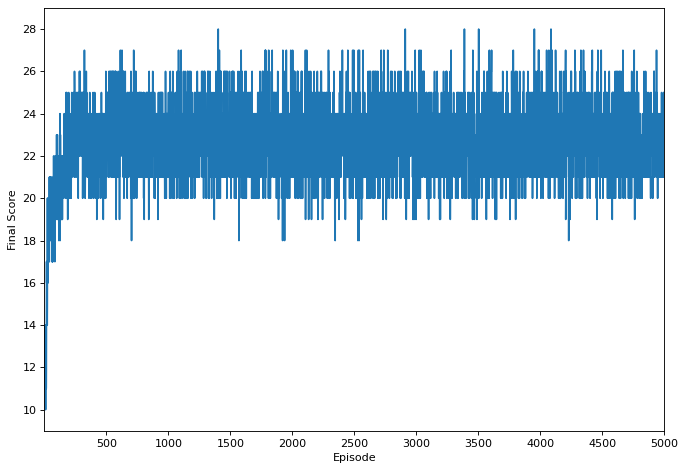

In [78]:
aux_plots.plot_scores(scores)

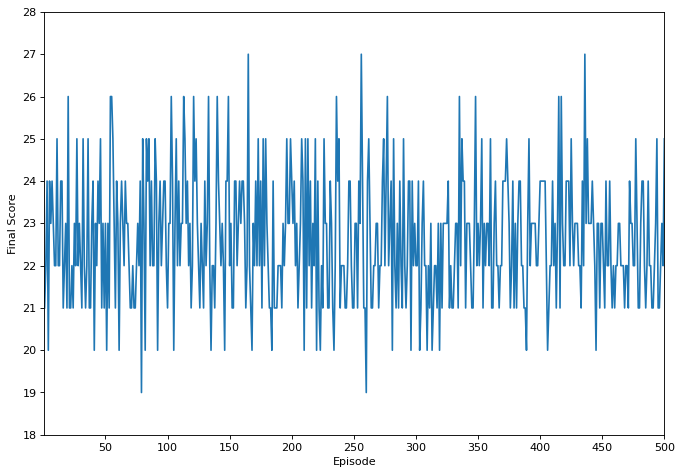

In [82]:
aux_plots.plot_scores(scores[4500:5000])

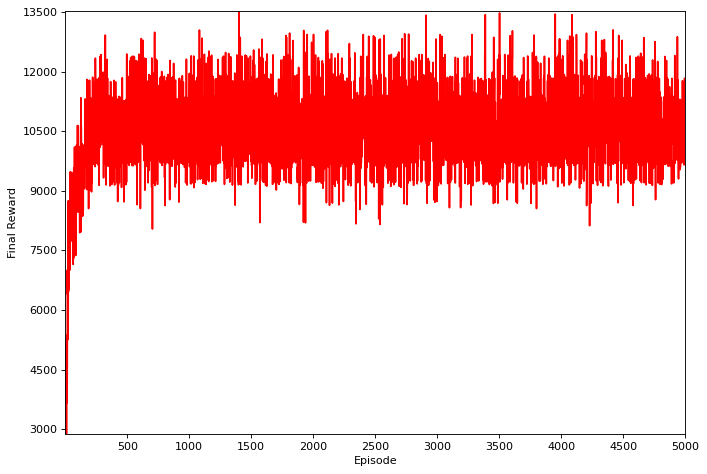

In [83]:
aux_plots.plot_rewards(total_rewards)

In [84]:
name="MontecarloAproximatorFeatureDistanceBiasR3_5000"

In [85]:
saveHistory(name,scores,total_rewards)

Scores and Total rewards for MontecarloAproximatorFeatureDistanceBiasR3_5000 saved


In [86]:
cwd = os.getcwd()

In [87]:
modelSavePath=cwd+"/models/"

In [88]:
exp = serializer.Experiment(agent, scores, total_rewards, reduce_state, reward_policy)
exp.save_experiment(modelSavePath,name)
print("Model saved!")

Model saved!
